# Wiggle

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [3]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [69]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [70]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    df_span = df_span[['_200_' in f for f in df_span['file']]]
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [71]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 85


,file,modification,cell,replicate,peaks,tool,dataset
201,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me1,Huvec,rep2,70741,SICER,ENCODE
174,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K36me3,NHLF,rep1,44110,SICER,ENCODE
73,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27me3,K562,rep1,9953,MACS2,ENCODE
196,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K4me1,K562,rep1,55839,SICER,ENCODE
281,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27me3,HSMM,rep2,37722,SPAN,ENCODE


In [72]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/50 [00:00<?, ?it/s]

SPAN 46


,file,modification,cell,replicate,peaks,tool,dataset
111,/home/jetbrains/data/2023_Immune/sicer/TCell_H...,H3K27me3,TCell,,67477,SICER,Roadmap
112,/home/jetbrains/data/2023_Immune/sicer/CD34_H3...,H3K4me3,CD34,,20673,SICER,Roadmap
17,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,H3K27me3,TCell,,283089,MACS2,Roadmap
39,/home/jetbrains/data/2023_Immune/macs2/CD4_H3K...,H3K27me3,CD4,rep2,8738,MACS2,Roadmap
92,/home/jetbrains/data/2023_Immune/sicer/TCell_H...,H3K4me3,TCell,,21785,SICER,Roadmap


In [73]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

In [74]:
# Remove outliers, see 2023 figures.ipynb
OUTLIERS = [('H3K4me3', 'NK', ''),
            ('H3K4me1', 'NK', ''),
            ('H3K27me3', 'TCell', ''),
            ('H3K27me3', 'NHLF', 'rep2'),
            ('H3K27me3', 'GM12878', 'rep1')]
df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS 
                         for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]]

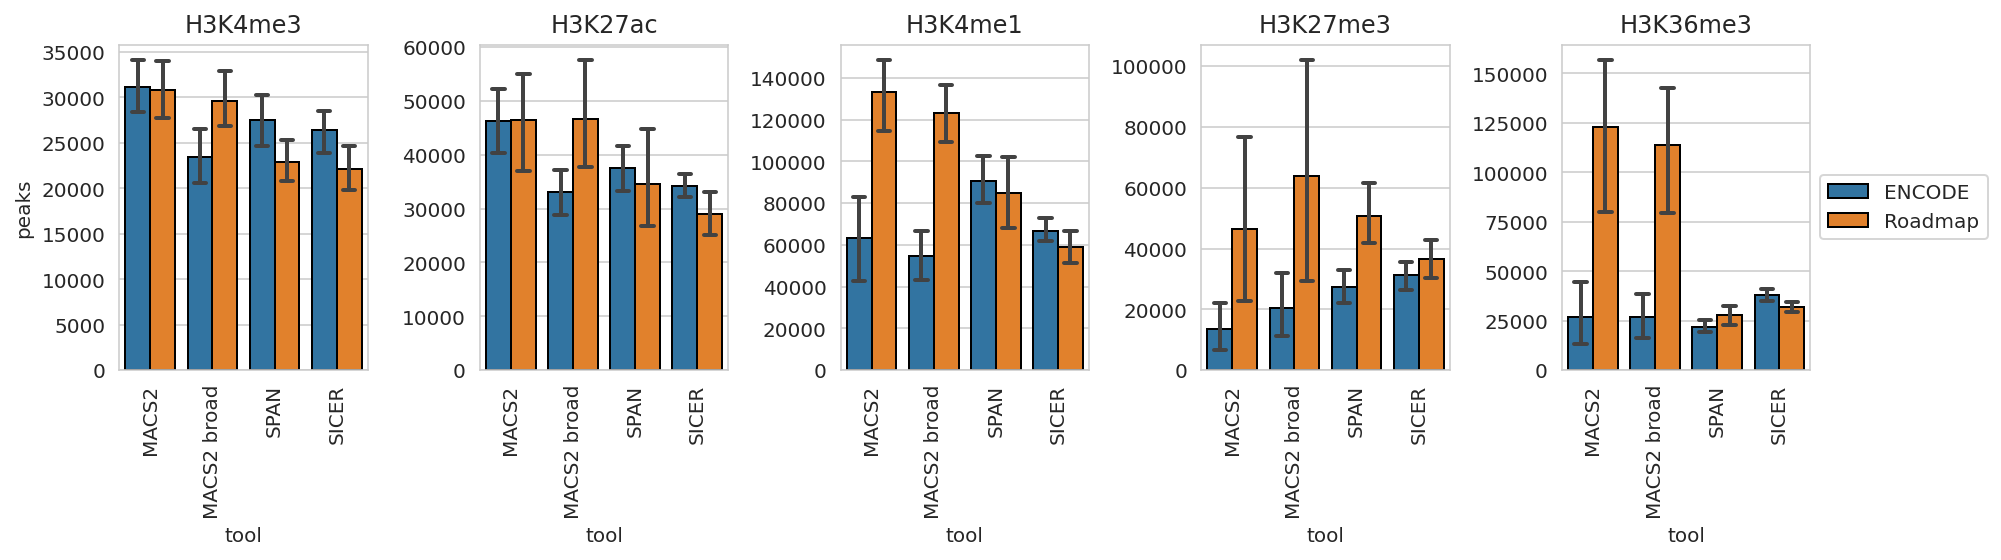

In [75]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    g_results = sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', ax=ax,
                            hue='dataset',
                            capsize=.2, errwidth=2, edgecolor="black",
                            # palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Inspect BAMs

In [25]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams


In [26]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_encode_bams

  0%|          | 0/206 [00:00<?, ?it/s]

,bam_file,modification,cell,replicate,reads,dataset
0,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K36me3,NHLF,rep1,14385159,ENCODE
1,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K36me3,NHEK,rep2,7569713,ENCODE
2,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,NHEK,rep1,9377615,ENCODE
3,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27me3,HSMM,rep2,8356060,ENCODE
4,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,K562,rep2,7777248,ENCODE
...,...,...,...,...,...,...
98,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,GM12878,rep1,5699825,ENCODE
99,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me3,NHEK,rep1,8169225,ENCODE
100,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,H1,rep2,2998695,ENCODE
101,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,HSMM,rep2,7218491,ENCODE


In [27]:
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'
df_immune_bams

  0%|          | 0/113 [00:00<?, ?it/s]

,bam_file,modification,cell,replicate,reads,dataset
0,/home/jetbrains/data/2023_Immune/bams/CD4ABT_C...,Control,CD4ABT,rep2,30734164,Roadmap
1,/home/jetbrains/data/2023_Immune/bams/CD4_Cont...,Control,CD4,,42504697,Roadmap
2,/home/jetbrains/data/2023_Immune/bams/TCell_Co...,Control,TCell,,35331343,Roadmap
3,/home/jetbrains/data/2023_Immune/bams/CD34_H3K...,H3K4me3,CD34,rep2,13539143,Roadmap
4,/home/jetbrains/data/2023_Immune/bams/CD34_H3K...,H3K27me3,CD34,,18465977,Roadmap
5,/home/jetbrains/data/2023_Immune/bams/NK_H3K4m...,H3K4me1,NK,,21502380,Roadmap
6,/home/jetbrains/data/2023_Immune/bams/CD4_H3K4...,H3K4me1,CD4,,20428604,Roadmap
7,/home/jetbrains/data/2023_Immune/bams/BCell_H3...,H3K27ac,BCell,,21067933,Roadmap
8,/home/jetbrains/data/2023_Immune/bams/CD34_H3K...,H3K27me3,CD34,rep2,15812841,Roadmap
9,/home/jetbrains/data/2023_Immune/bams/CD4_H3K2...,H3K27ac,CD4,,14516237,Roadmap


In [28]:
df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)

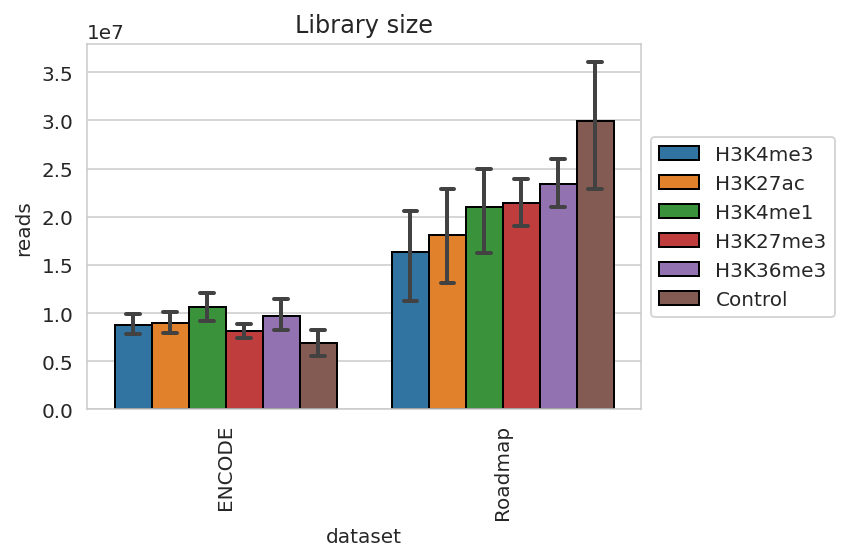

In [29]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams,
                        hue='modification', x='dataset', y='reads', ax=ax,
                        capsize=.05, errwidth=2, edgecolor="black",
                        hue_order=MODIFICATIONS+['Control']
                        )
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

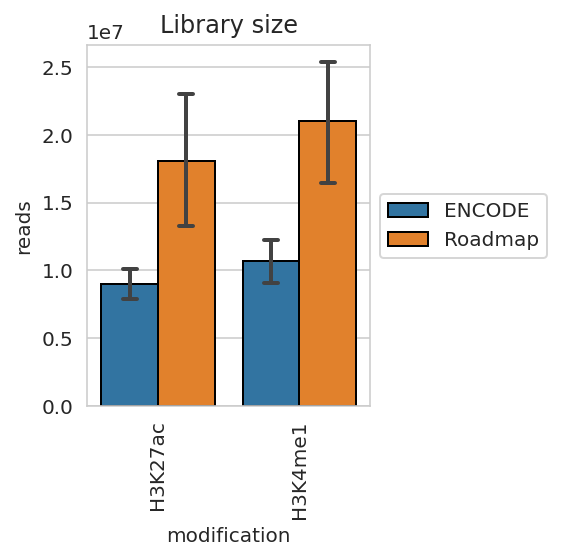

In [30]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_bams[(df_bams['modification'] == 'H3K27ac') | (df_bams['modification'] == 'H3K4me1')],
                        hue='dataset', x='modification', y='reads', ax=ax,
                        capsize=.1, errwidth=2, edgecolor="black",
                        )
# ax.set_ylim(0, 160_000)
ax.set_title('Library size')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Downsample Roadmap to 10M reads

In [115]:
DOWNSAMPLED_PATH = os.path.expanduser('~/data/2023_Immune_10M')
! mkdir -p {DOWNSAMPLED_PATH}/bams

In [116]:
tf = tempfile.mktemp()
for _, (bam_file, reads) in tqdm(
        list(df_immune_bams[df_immune_bams['cell'].isin(['BCell', 'TCell', 'Monocyte'])][['bam_file', 'reads']].iterrows())):
    ds_bam_file = f'{DOWNSAMPLED_PATH}/bams/{os.path.basename(bam_file.replace(".bam", "_10M.bam"))}'
    print(ds_bam_file)
    if not os.path.exists(ds_bam_file):
        fraction = 1e7 / reads
        print('Downsampling')
        ! samtools view -@ 4 -H {bam_file} > {tf}.sam
        ! samtools view -@ 4 -s {fraction} {bam_file} >> {tf}.sam
        ! samtools view -S -b {tf}.sam > {tf}.bam
        ! samtools sort {tf}.bam -o {ds_bam_file}
        ! rm {tf}.sam {tf}.bam

  0%|          | 0/18 [00:00<?, ?it/s]

/home/jetbrains/data/2023_Immune_10M/bams/TCell_Control_hg38_ENCFF566HDE_10M.bam
/home/jetbrains/data/2023_Immune_10M/bams/BCell_H3K27ac_hg38_ENCFF404HKA_10M.bam
/home/jetbrains/data/2023_Immune_10M/bams/TCell_H3K4me3_hg38_ENCFF661HCG_10M.bam
/home/jetbrains/data/2023_Immune_10M/bams/BCell_H3K4me1_hg38_ENCFF584OXC_10M.bam
/home/jetbrains/data/2023_Immune_10M/bams/BCell_H3K36me3_hg38_ENCFF207YSM_10M.bam
/home/jetbrains/data/2023_Immune_10M/bams/Monocyte_H3K27me3_gh38_ENCFF850DZD_10M.bam
/home/jetbrains/data/2023_Immune_10M/bams/BCell_Control_hg38_ENCFF198QJK_10M.bam
/home/jetbrains/data/2023_Immune_10M/bams/Monocyte_H3K4me3_hg38_ENCFF642LZZ_10M.bam
/home/jetbrains/data/2023_Immune_10M/bams/TCell_H3K4me1_hg38_ENCFF737JXT_10M.bam
/home/jetbrains/data/2023_Immune_10M/bams/BCell_H3K27me3_hg38_ENCFF118UGM_10M.bam
/home/jetbrains/data/2023_Immune_10M/bams/TCell_H3K27me3_hg38_ENCFF192QMJ_10M.bam
/home/jetbrains/data/2023_Immune_10M/bams/TCell_H3K36me3_hg38_ENCFF783YIM_10M.bam
/home/jetbrains/d

## Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams span=True sicer=True span_bin=200 span_gap=0 --rerun-trigger mtime; 

```

In [127]:
df_immune_downsampled = load_peaks_path(DOWNSAMPLED_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_downsampled.sample(3)

  0%|          | 0/120 [00:00<?, ?it/s]

MACS2 15


  0%|          | 0/120 [00:00<?, ?it/s]

MACS2 broad 15


  0%|          | 0/15 [00:00<?, ?it/s]

SICER 15


  0%|          | 0/18 [00:00<?, ?it/s]

SPAN 15


,file,modification,cell,replicate,peaks,tool
21,/home/jetbrains/data/2023_Immune_10M/macs2/Mon...,H3K27me3,Monocyte,,51238,MACS2 broad
16,/home/jetbrains/data/2023_Immune_10M/macs2/TCe...,H3K4me3,TCell,,25336,MACS2 broad
44,/home/jetbrains/data/2023_Immune_10M/sicer/Mon...,H3K4me3,Monocyte,,17025,SICER


In [128]:
t1 = df_immune_downsampled.copy()
t1['reads'] = 10
t2 = df_immune_peaks.copy()
t2['reads'] = 20
df_downsample = pd.concat([t1, t2]).reset_index(drop=True)
df_downsample['reads'] = df_downsample['reads'].astype(str) + 'M'

df_downsample

,file,modification,cell,replicate,peaks,tool,reads,dataset
0,/home/jetbrains/data/2023_Immune_10M/macs2/BCe...,H3K27me3,BCell,,34043,MACS2,10M,NaN
1,/home/jetbrains/data/2023_Immune_10M/macs2/BCe...,H3K4me1,BCell,,112650,MACS2,10M,NaN
2,/home/jetbrains/data/2023_Immune_10M/macs2/Mon...,H3K27ac,Monocyte,,43585,MACS2,10M,NaN
3,/home/jetbrains/data/2023_Immune_10M/macs2/Mon...,H3K4me1,Monocyte,,123260,MACS2,10M,NaN
4,/home/jetbrains/data/2023_Immune_10M/macs2/BCe...,H3K36me3,BCell,,137165,MACS2,10M,NaN
...,...,...,...,...,...,...,...,...
239,/home/jetbrains/data/2023_Immune/span/Monocyte...,H3K27me3,Monocyte,,38153,SPAN,20M,Roadmap
240,/home/jetbrains/data/2023_Immune/span/CD4_H3K2...,H3K27me3,CD4,rep2,68235,SPAN,20M,Roadmap
241,/home/jetbrains/data/2023_Immune/span/CD4_H3K4...,H3K4me1,CD4,,69107,SPAN,20M,Roadmap
242,/home/jetbrains/data/2023_Immune/span/TCell_H3...,H3K27me3,TCell,,115929,SPAN,20M,Roadmap


H3K27ac
H3K4me1


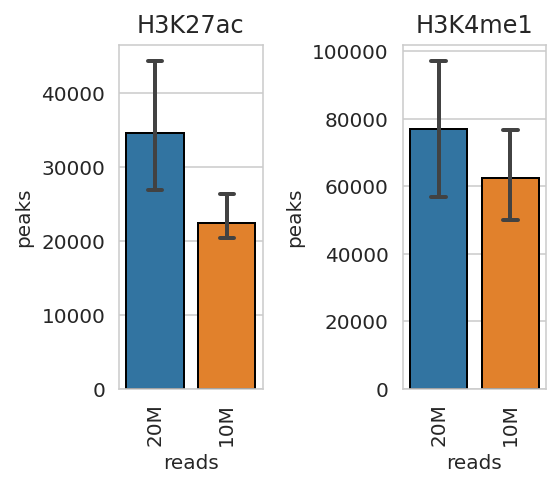

In [129]:
plt.figure(figsize=(4, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=df_downsample[(df_downsample['modification'] == m) &
                                               (df_downsample['tool'] == 'SPAN')],
                            x='reads', y='peaks', ax=ax,
                            capsize=.2, errwidth=2, edgecolor="black",
                            order=['20M', '10M'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K27ac
H3K4me1


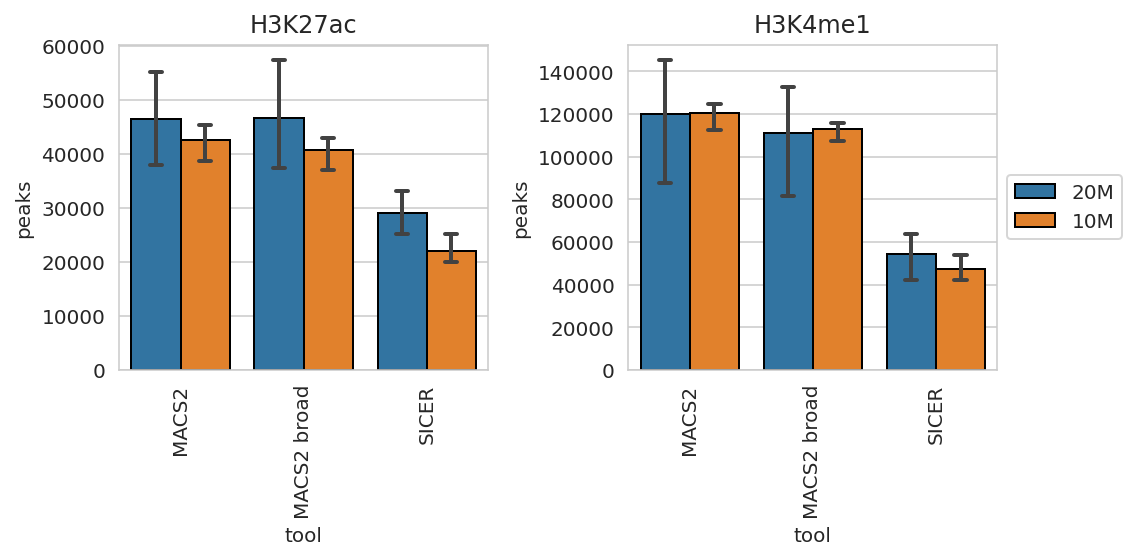

In [130]:
plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=df_downsample[df_downsample['modification'] == m],
                            hue='reads', x='tool', y='peaks', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            order=['MACS2', 'MACS2 broad', 'SICER'],
                            hue_order=['20M', '10M'],
                            )
    # ax.set_ylim(0, 160_000)
    ax.set_title(m)
    if i != 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [131]:
df_downsample_fc = pd.DataFrame(columns=['modification', 'cell', 'replicate', 'tool',
                                         'peaks20M', 'peaks10M', 'diff%'])
t = df_downsample[df_downsample['reads'] == '20M']
for m, c, r, to, p in tqdm(zip(t['modification'], t['cell'], t['replicate'], t['tool'], t['peaks'])):
    print(m, c, r, to, p)
    t10 = df_downsample[(df_downsample['reads'] == '10M') &
                        (df_downsample['modification'] == m) &
                        (df_downsample['cell'] == c) &
                        (df_downsample['replicate'] == r) &
                        (df_downsample['tool'] == to)]
    if len(t10) == 0:
        continue
    p10 = t10['peaks'].values[0]
    df_downsample_fc.loc[len(df_downsample_fc)] = (m, c, r, to, p, p10, int(100 * d(p10 - p, p)))
df_downsample_fc.sample(3)

0it [00:00, ?it/s]

H3K27ac PBMC  MACS2 36545
H3K36me3 CD4 rep1 MACS2 28
H3K27me3 PBMC  MACS2 17158
H3K4me1 TCell  MACS2 158205
H3K4me3 CD34 rep2 MACS2 27221
H3K27me3 CD34 rep2 MACS2 81061
H3K27ac CD4 rep1 MACS2 24239
H3K27ac NK  MACS2 54313
H3K4me3 TCellBB rep1 MACS2 39930
H3K4me3 CD4ABT rep1 MACS2 25997
H3K36me3 CD34  MACS2 154337
H3K4me3 Monocyte  MACS2 26555
H3K4me3 TCellBB rep2 MACS2 35225
H3K27me3 Monocyte  MACS2 57580
H3K4me1 Monocyte  MACS2 124907
H3K4me3 PBMC  MACS2 25166
H3K27me3 BCell  MACS2 120947
H3K27me3 TCell  MACS2 283089
H3K36me3 Monocyte  MACS2 127115
H3K4me1 CD34 rep2 MACS2 148922
H3K4me1 CD34  MACS2 153731
H3K4me1 CD4 rep1 MACS2 89320
H3K27ac CD34  MACS2 64970
H3K4me1 BCell  MACS2 141414
H3K27ac CD4  MACS2 61162
H3K27ac TCell  MACS2 57350
H3K4me3 TCell  MACS2 31242
H3K4me1 NK  MACS2 26931
H3K4me1 CD4  MACS2 117825
H3K36me3 CD4  MACS2 107248
H3K36me3 CD34 rep1 MACS2 122980
H3K27ac Monocyte  MACS2 47324
H3K27me3 CD34  MACS2 53084
H3K4me3 NK  MACS2 131599
H3K36me3 TCell  MACS2 183613
H3K4

,modification,cell,replicate,tool,peaks20M,peaks10M,diff%
4,H3K27me3,BCell,,MACS2,120947,34043,-71
45,H3K36me3,Monocyte,,SPAN,30297,25399,-16
25,H3K27me3,BCell,,MACS2 broad,187656,69304,-63


H3K27ac
H3K4me1


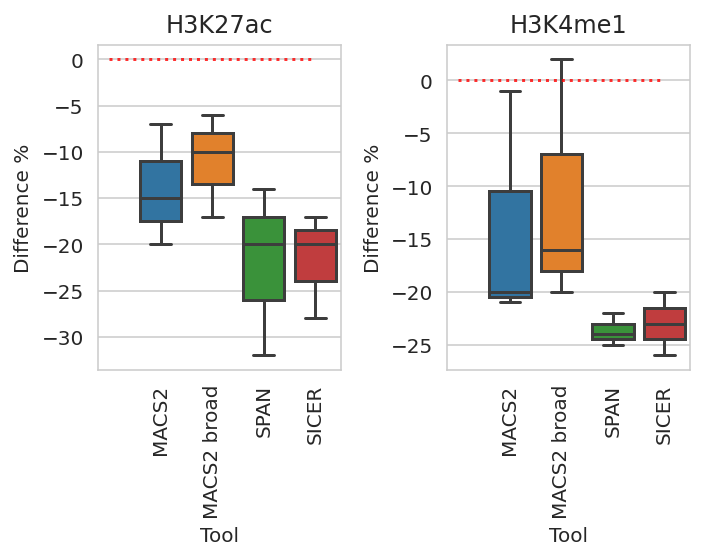

In [132]:
plt.figure(figsize=(5, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.boxplot(data=df_downsample_fc[df_downsample_fc['modification'] == m],
                            x='tool', y='diff%', ax=ax,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            )
    ax.set_title(m)
    sns.lineplot(x=[-1, 3], y=[0, 0], color='red', ax=ax, alpha=0.8, linestyle='dotted')
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Difference %')
    ax.set_xlabel('Tool')

plt.tight_layout()
plt.show()

In [133]:
print('Load lengths')
ts = []
for mod, signal_reads, file, tool in tqdm(zip(
        df_downsample['modification'], df_downsample['reads'], df_downsample['file'], df_downsample['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['modification'] = mod
    t['reads'] = signal_reads
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

,length,modification,reads,tool
271487,590,H3K36me3,10M,MACS2 broad
789345,1352,H3K4me1,20M,MACS2
1804866,5799,H3K27ac,20M,SICER
2072732,1336,H3K27me3,20M,SPAN
1028127,386,H3K27me3,20M,MACS2
1419582,313,H3K4me3,20M,MACS2 broad
1762946,2599,H3K27me3,20M,SICER
37967,235,H3K4me1,10M,MACS2
83153,2070,H3K4me3,10M,MACS2
2004165,4328,H3K4me3,20M,SPAN


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


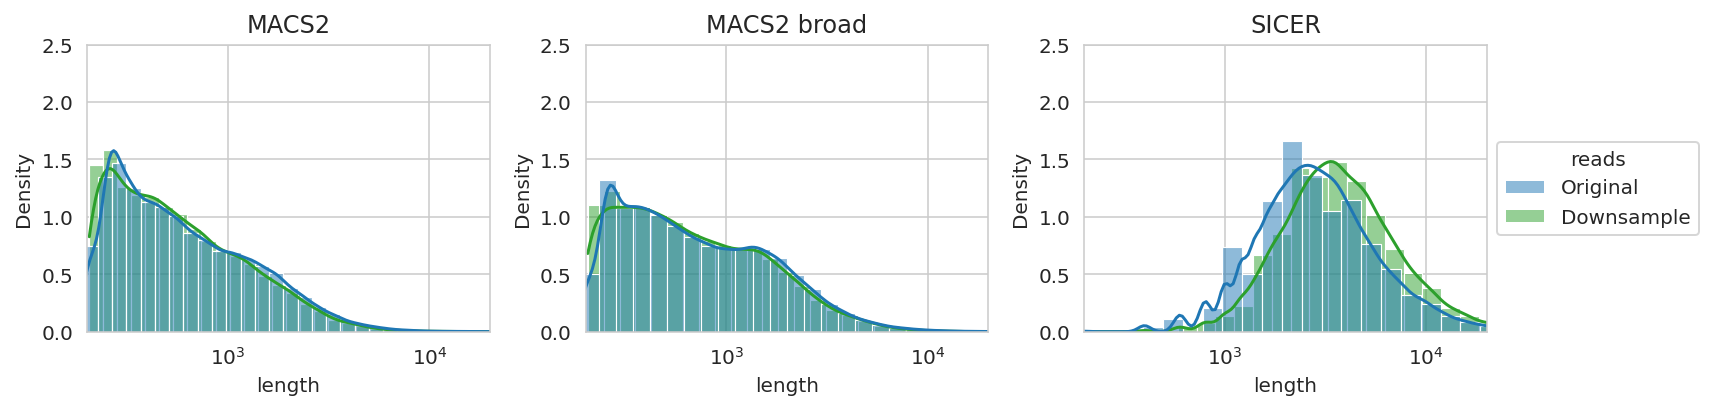

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


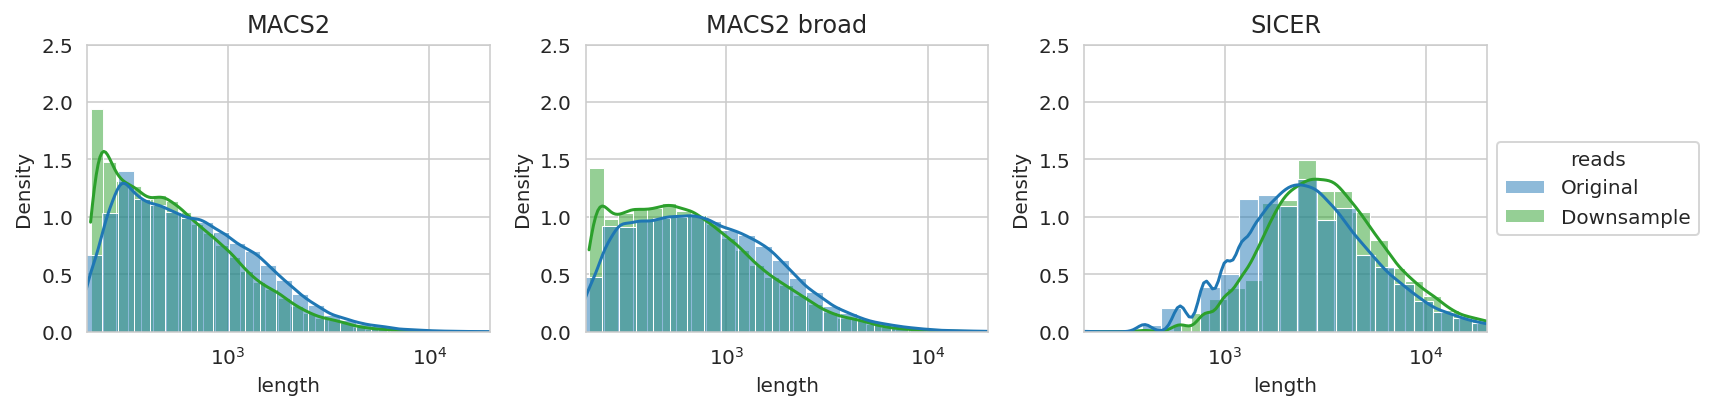

In [134]:
palette = plt.cm.get_cmap('tab10')
READS_PALETTE = {'Original': palette(0), 'Downsample': palette(2)}

t.loc[t['reads'] == '20M', 'reads'] = 'Original'
t.loc[t['reads'] == '10M', 'reads'] = 'Downsample'

for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(12, 3))

    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == tool)],
                                 x='length', hue='reads', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 palette=READS_PALETTE,
                                 hue_order=['Original', 'Downsample'],
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


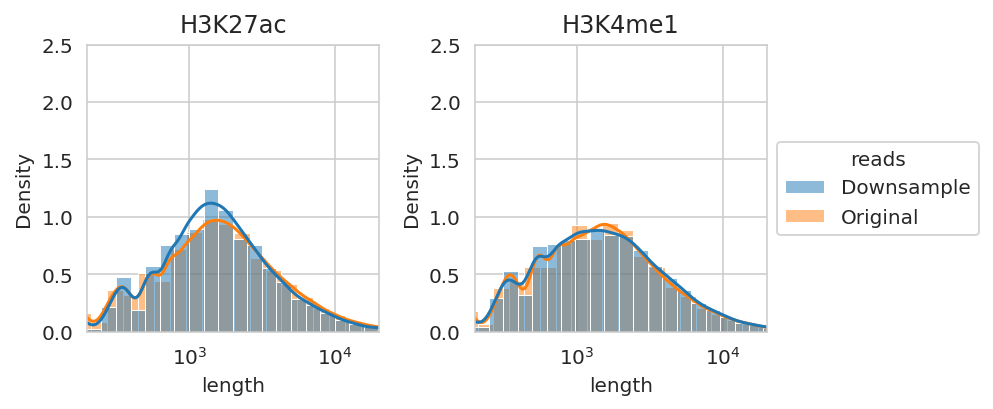

In [135]:
palette = plt.cm.get_cmap('tab10')
READS_PALETTE = {'20M': palette(0), '10M': palette(1)}

t['dataset'] = t['modification'] + ' ' + t['reads']

plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification'] == m) & (t['tool'] == 'SPAN')],
                             x='length', hue='reads', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # hue_order=['20M', '10M'],
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


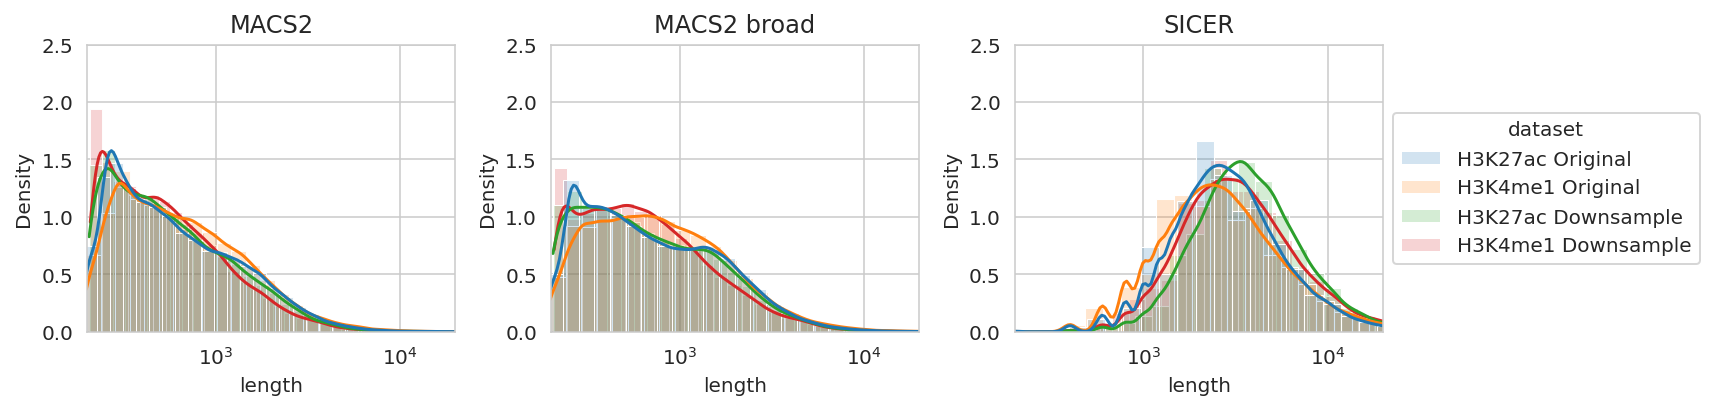

In [140]:
t['dataset'] = t['modification'] + ' ' + t['reads']

plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
    ax = axs[i]
    tt = t[((t['modification'] == 'H3K27ac') | (t['modification'] == 'H3K4me1')) & (t['tool'] == tool)]
    g_results = sns.histplot(
        data=tt,
        x='length', hue='dataset', ax=ax,
        stat='density', common_bins=False, common_norm=False,
        bins=30, kde=True, log_scale=True, alpha=0.2,
        hue_order=['H3K27ac Original', 'H3K4me1 Original', 'H3K27ac Downsample', 'H3K4me1 Downsample'],
        # palette=READS_PALETTE,
    )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{tool}')
    if i < 2:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


## Jaccard original vs downsampled

In [141]:
bench_df = pd.DataFrame(
    columns=['modification', 'cell', 'replicate', 'name', 'quality',
             'original_peaks', 'original_peaks_len',
             'peaks', 'peaks_len', 'overlap1', 'overlap2', 'overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()

for m, c, r, tool in tqdm(product(['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, IMMUNE_REPS, TOOLS)):
    print(m, c, r, tool)
    t = df_downsample[
        (df_downsample['modification'] == m) &
        (df_downsample['cell'] == c) &
        (df_downsample['replicate'] == r) &
        (df_downsample['tool'] == tool) &
        (df_downsample['reads'] == '20M')]
    if len(t) == 0:
        print('-')
        continue
    original_file = sorted_file(t['file'].values[0])
    original_peaks = lines(original_file)
    original_peaks_len = int(bedl(original_file).sum())
    t = df_downsample[
        (df_downsample['modification'] == m) &
        (df_downsample['cell'] == c) &
        (df_downsample['replicate'] == r) &
        (df_downsample['tool'] == tool) &
        (df_downsample['reads'] == '10M')]
    if len(t) == 0:
        continue
    file = sorted_file(t['file'].values[0])
    peaks_len = int(bedl(file).sum())
    !bedtools intersect -a {original_file} -b {file} -wa -u > {tf}
    overlap1 = lines(tf)
    !bedtools intersect -b {original_file} -a {file} -wa -u > {tf}
    overlap2 = lines(tf)
    !bedtools intersect -a {original_file} -b {file} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    bench_df.loc[len(bench_df)] = \
        (m, c, r, tool, '10M',
         original_peaks, original_peaks_len,
         (lines(file)), peaks_len, overlap1, overlap2, overlap_len)
bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['original_peaks_len'], bench_df['peaks_len'], bench_df['overlap_len'])
]
bench_df.sample(3)

0it [00:00, ?it/s]

H3K27ac CD4ABT rep1 MACS2
-
H3K27ac CD4ABT rep1 MACS2 broad
-
H3K27ac CD4ABT rep1 SPAN
-
H3K27ac CD4ABT rep1 SICER
-
H3K27ac CD4ABT rep2 MACS2
-
H3K27ac CD4ABT rep2 MACS2 broad
-
H3K27ac CD4ABT rep2 SPAN
-
H3K27ac CD4ABT rep2 SICER
-
H3K27ac CD4ABT rep3 MACS2
-
H3K27ac CD4ABT rep3 MACS2 broad
-
H3K27ac CD4ABT rep3 SPAN
-
H3K27ac CD4ABT rep3 SICER
-
H3K27ac CD4ABT  MACS2
-
H3K27ac CD4ABT  MACS2 broad
-
H3K27ac CD4ABT  SPAN
-
H3K27ac CD4ABT  SICER
-
H3K27ac TCellBB rep1 MACS2
-
H3K27ac TCellBB rep1 MACS2 broad
-
H3K27ac TCellBB rep1 SPAN
-
H3K27ac TCellBB rep1 SICER
-
H3K27ac TCellBB rep2 MACS2
-
H3K27ac TCellBB rep2 MACS2 broad
-
H3K27ac TCellBB rep2 SPAN
-
H3K27ac TCellBB rep2 SICER
-
H3K27ac TCellBB rep3 MACS2
-
H3K27ac TCellBB rep3 MACS2 broad
-
H3K27ac TCellBB rep3 SPAN
-
H3K27ac TCellBB rep3 SICER
-
H3K27ac TCellBB  MACS2
-
H3K27ac TCellBB  MACS2 broad
-
H3K27ac TCellBB  SPAN
-
H3K27ac TCellBB  SICER
-
H3K27ac BCell rep1 MACS2
-
H3K27ac BCell rep1 MACS2 broad
-
H3K27ac BCell rep1 S

,modification,cell,replicate,name,quality,original_peaks,original_peaks_len,peaks,peaks_len,overlap1,overlap2,overlap_len,jaccard
1,H3K27ac,BCell,,MACS2 broad,10M,41460,46789660,37017,36345943,30175,35461,35246812,0.736014
2,H3K27ac,BCell,,SPAN,10M,25577,68916078,20352,47907581,19319,20340,47760686,0.691553
5,H3K27ac,TCell,,MACS2 broad,10M,51740,63370004,42845,42902410,31688,41037,41746865,0.646982


H3K27ac
H3K4me1


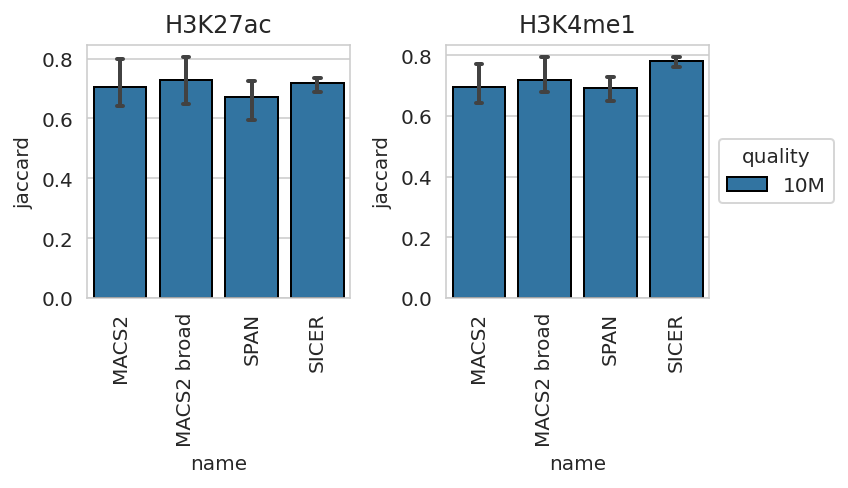

In [142]:
plt.figure(figsize=(6, 3.5))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.barplot(data=bench_df[bench_df['modification'] == m],
                            x='name', hue='quality', y='jaccard', ax=ax,
                            capsize=.1, errwidth=2, edgecolor="black",
                            # hue_order=['wiggle', 'mix'],
                            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            # palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(m)
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.set_ylim(0, 55_000)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Wiggle

In [31]:
# Prepare BAM files
WD = os.path.expanduser('~/data/2023_wiggle')
! mkdir -p {WD}/bed

df_bam_beds = df_bams[(df_bams['modification'].isin(['H3K27ac', 'H3K4me1', 'Control'])) & 
                      (df_bams['dataset'] == 'ENCODE')].copy()
df_bam_beds

,bam_file,modification,cell,replicate,reads,dataset
2,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,NHEK,rep1,9377615,ENCODE
4,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,K562,rep2,7777248,ENCODE
5,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,K562,rep1,10381382,ENCODE
7,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,HepG2,rep2,5132356,ENCODE
9,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,NHEK,rep2,7402469,ENCODE
10,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,HMEC,rep1,3750119,ENCODE
12,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,HMEC,rep1,10940745,ENCODE
13,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,GM12878,rep1,11008158,ENCODE
14,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,HSMM,rep1,8080332,ENCODE
15,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,H1,rep1,10076569,ENCODE


In [33]:
beds = []
for _, (bam_file, m, c, r, _, _) in tqdm(df_bam_beds.iterrows()):
    bed_file = f'{WD}/bed/{os.path.basename(bam_file).replace(".bam", ".bed")}'
    print(bed_file)
    beds.append(bed_file)
    if not os.path.exists(bed_file):
        ! bamToBed -i {bam_file} > {bed_file}
df_bam_beds['bed_file'] = beds
df_bam_beds.sample(3)

0it [00:00, ?it/s]

/home/jetbrains/data/2023_wiggle/bed/GSM646456_NHEK_H3K27ac_rep1.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646441_K562_H3K4me1_rep2.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646452_K562_Input_rep1.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646356_HepG2_H3K27ac_rep2.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646473_NHEK_Input_rep2.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646390_HMEC_Input_rep1.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646374_HMEC_H3K27ac_rep1.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646322_GM12878_H3K4me1_rep1.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646400_HSMM_H3K4me1_rep1.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646351_H1_Input_rep1.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646380_HMEC_H3K4me1_rep1.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646414_Huvec_H3K27ac_rep1.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646317_GM12878_H3K27ac_rep2.bed
/home/jetbrains/data/2023_wiggle/bed/GSM646477_NHLF_H3K27ac_rep2.bed
/home/jetbrains/data/2023_wiggle/bed

,bam_file,modification,cell,replicate,reads,dataset,bed_file
68,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,K562,rep2,6180094,ENCODE,/home/jetbrains/data/2023_wiggle/bed/GSM646435...
100,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,H1,rep2,2998695,ENCODE,/home/jetbrains/data/2023_wiggle/bed/GSM646352...
17,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K27ac,Huvec,rep1,12283487,ENCODE,/home/jetbrains/data/2023_wiggle/bed/GSM646414...


## Create wiggle BAMs

In [34]:
! mkdir -p {WD}/bams

tf1 = tempfile.mktemp()
tf2 = tempfile.mktemp()
tf3 = tempfile.mktemp()
tf4 = tempfile.mktemp()

NUPSCALE = 10
FRACTION_SIGNAL = 80
FRACTION_WIGGLE = 100 - FRACTION_SIGNAL

for var_upscale, var_wiggle in tqdm(product([1, 2], [0, 2000])):
    if var_upscale == 1 and var_wiggle == 0:
        continue
    var_name = '' if var_upscale == 1 else f'x{var_upscale}_N{NUPSCALE}'
    if var_wiggle != 0:
        if var_name != '':
            var_name += '_'
        var_name += f'w{int(FRACTION_SIGNAL)}_{int(FRACTION_WIGGLE)}_N{var_wiggle}'
    print('upscale', var_upscale, 'wiggle', var_wiggle, 'Type', var_name)

    wiggles = []
    for _, (bam_file, m, c, r, bed_file) in tqdm(
            df_bam_beds[['bam_file', 'modification', 'cell', 'replicate', 'bed_file']].iterrows()
    ):
        print(var_name, m, c, r, bed_file)
        if m == 'Control':
            wiggles.append(None)
            ! ln -sf {bam_file} {WD}/bams/{os.path.basename(bam_file)} 
            continue
        print('Signal', FRACTION_SIGNAL, 'wiggle', FRACTION_WIGGLE)
        result_file = f'{WD}/bams/{m}_{c}_{r}_{var_name}.bam'
        wiggles.append(result_file)
        print(result_file)
        if os.path.exists(result_file):
            continue
        t = pd.read_csv(bed_file, sep='\t', header=None)
        print('Reads', len(t))
    
        if var_upscale != 1:
            print('Upscale coverage')
            if var_upscale == 2:
                t_copy = t.copy()  # Double coverage
            elif var_upscale == 1.5:
                t_copy = t.sample(int(len(t) * 0.5)).copy() # +50% coverage
            else:
                raise Exception(f'Unknown var_upscale {var_upscale}')
            delta_small = [int(x) for x in np.random.normal(0, NUPSCALE, size=len(t_copy))]
            t_copy[1] += delta_small
            t_copy[2] += delta_small
            del delta_small
            # Ensure generated reads have proper coordinates
            t_copy.loc[t_copy[1] < 1, 1] = 1
            t_copy.loc[t_copy[2] < 1, 2] = 1
            t = pd.concat([t, t_copy]).reset_index(drop=True) 
            print('Upscaled coverage', len(t))
        
        if var_wiggle != 0:
            print('wiggle')
            signal = t.sample(int(len(t) * FRACTION_SIGNAL * 0.01))
            noise = t.sample(int(len(t) * FRACTION_WIGGLE * 0.01))
            delta = [int(x) for x in np.random.normal(0, var_wiggle, size=len(noise))]
            noise[1] += delta
            noise[2] += delta
            # Ensure generated reads have proper coordinates
            noise.loc[noise[1] < 1, 1] = 1
            noise.loc[noise[2] < 1, 2] = 1
            signal.to_csv(tf1, sep='\t', index=False, header=None)
            noise.to_csv(tf2, sep='\t', index=False, header=None)
            del t, signal, noise, delta
            ! cat {tf1} > {tf3}
            ! cat {tf2} >> {tf3}
            ! rm {tf1} {tf2}
        else:
            t.to_csv(tf3, sep='\t', index=False, header=None)
            del t
        ! cat {tf3} | sort -k1,1 -k2,2n -k3,3n > {tf4}
        ! rm {tf3}
        ! bedToBam -i {tf4} -g {WD}/hg38.chrom.sizes > {result_file}
        ! rm {tf4}
        print('Done', result_file)
    df_bam_beds[var_name] = wiggles
df_bam_beds.sample(3)

0it [00:00, ?it/s]

upscale 1 wiggle 2000 Type w80_19_N2000


0it [00:00, ?it/s]

w80_19_N2000 H3K27ac NHEK rep1 /home/jetbrains/data/2023_wiggle/bed/GSM646456_NHEK_H3K27ac_rep1.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_wiggle/bams/H3K27ac_NHEK_rep1_w80_19_N2000.bam
Reads 9377615
wiggle
Done /home/jetbrains/data/2023_wiggle/bams/H3K27ac_NHEK_rep1_w80_19_N2000.bam
w80_19_N2000 H3K4me1 K562 rep2 /home/jetbrains/data/2023_wiggle/bed/GSM646441_K562_H3K4me1_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_wiggle/bams/H3K4me1_K562_rep2_w80_19_N2000.bam
Reads 7777248
wiggle
Done /home/jetbrains/data/2023_wiggle/bams/H3K4me1_K562_rep2_w80_19_N2000.bam
w80_19_N2000 Control K562 rep1 /home/jetbrains/data/2023_wiggle/bed/GSM646452_K562_Input_rep1.bed
w80_19_N2000 H3K27ac HepG2 rep2 /home/jetbrains/data/2023_wiggle/bed/GSM646356_HepG2_H3K27ac_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_wiggle/bams/H3K27ac_HepG2_rep2_w80_19_N2000.bam
Reads 5132356
wiggle
Done /home/jetbrains/data/2023_wiggle/bams/H3K2

0it [00:00, ?it/s]

x2_N10 H3K27ac NHEK rep1 /home/jetbrains/data/2023_wiggle/bed/GSM646456_NHEK_H3K27ac_rep1.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_wiggle/bams/H3K27ac_NHEK_rep1_x2_N10.bam
Reads 9377615
Upscale coverage
Upscaled coverage 18755230
Done /home/jetbrains/data/2023_wiggle/bams/H3K27ac_NHEK_rep1_x2_N10.bam
x2_N10 H3K4me1 K562 rep2 /home/jetbrains/data/2023_wiggle/bed/GSM646441_K562_H3K4me1_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_wiggle/bams/H3K4me1_K562_rep2_x2_N10.bam
Reads 7777248
Upscale coverage
Upscaled coverage 15554496
Done /home/jetbrains/data/2023_wiggle/bams/H3K4me1_K562_rep2_x2_N10.bam
x2_N10 Control K562 rep1 /home/jetbrains/data/2023_wiggle/bed/GSM646452_K562_Input_rep1.bed
x2_N10 H3K27ac HepG2 rep2 /home/jetbrains/data/2023_wiggle/bed/GSM646356_HepG2_H3K27ac_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_wiggle/bams/H3K27ac_HepG2_rep2_x2_N10.bam
Reads 5132356
Upscale coverage
Upscaled coverage

0it [00:00, ?it/s]

x2_N10_w80_19_N2000 H3K27ac NHEK rep1 /home/jetbrains/data/2023_wiggle/bed/GSM646456_NHEK_H3K27ac_rep1.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_wiggle/bams/H3K27ac_NHEK_rep1_x2_N10_w80_19_N2000.bam
Reads 9377615
Upscale coverage
Upscaled coverage 18755230
wiggle
Done /home/jetbrains/data/2023_wiggle/bams/H3K27ac_NHEK_rep1_x2_N10_w80_19_N2000.bam
x2_N10_w80_19_N2000 H3K4me1 K562 rep2 /home/jetbrains/data/2023_wiggle/bed/GSM646441_K562_H3K4me1_rep2.bed
Signal 0.8 wiggle 0.19999999999999996
/home/jetbrains/data/2023_wiggle/bams/H3K4me1_K562_rep2_x2_N10_w80_19_N2000.bam
Reads 7777248
Upscale coverage
Upscaled coverage 15554496
wiggle
Done /home/jetbrains/data/2023_wiggle/bams/H3K4me1_K562_rep2_x2_N10_w80_19_N2000.bam
x2_N10_w80_19_N2000 Control K562 rep1 /home/jetbrains/data/2023_wiggle/bed/GSM646452_K562_Input_rep1.bed
x2_N10_w80_19_N2000 H3K27ac HepG2 rep2 /home/jetbrains/data/2023_wiggle/bed/GSM646356_HepG2_H3K27ac_rep2.bed
Signal 0.8 wiggle 0.1999999999999999

,bam_file,modification,cell,replicate,reads,dataset,bed_file,w80_19_N2000,x2_N10,x2_N10_w80_19_N2000
30,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,Control,HMEC,rep2,10342115,ENCODE,/home/jetbrains/data/2023_wiggle/bed/GSM646391...,None,None,None
56,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,Huvec,rep2,12419173,ENCODE,/home/jetbrains/data/2023_wiggle/bed/GSM646421...,/home/jetbrains/data/2023_wiggle/bams/H3K4me1_...,/home/jetbrains/data/2023_wiggle/bams/H3K4me1_...,/home/jetbrains/data/2023_wiggle/bams/H3K4me1_...
13,/home/jetbrains/data/2023_GSE26320/bams/GSM646...,H3K4me1,GM12878,rep1,11008158,ENCODE,/home/jetbrains/data/2023_wiggle/bed/GSM646322...,/home/jetbrains/data/2023_wiggle/bams/H3K4me1_...,/home/jetbrains/data/2023_wiggle/bams/H3K4me1_...,/home/jetbrains/data/2023_wiggle/bams/H3K4me1_...


## Estimate generated BAMs

In [121]:
# df_wiggle_bams = load_bams(WD + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
# df_wiggle_bams.sample(3)

In [122]:
# df_wiggle_bams['type'] = [re.sub('.*rep[12]_|\.bam|_q.*|-W.*|_broad.*|_100_.*', '', os.path.basename(f)) for f in df_wiggle_bams['bam_file']]
# df_wiggle_bams['upscale'] = [None if 'x' not in ty else float(re.sub('x|_N.*', '', ty)) for ty in df_wiggle_bams['type']]
# df_wiggle_bams['wiggle'] = [None if 'w' not in ty else int(re.sub('.*_N', '', ty)) for ty in df_wiggle_bams['type']]
# # # Limit to x2_N20 and wiggle 5000
# # df_wiggle_bams = df_wiggle_bams[(df_wiggle_bams['upscale'] != 1.5) &
# #                                 (~df_wiggle_bams['type'].str.contains('N100')) &
# #                                 (df_wiggle_bams['wiggle'] != 2000)]
# 
# df_wiggle_bams

In [123]:
# df_immune_10m_bams = load_bams(IMMUNE_PATH + '_10M/bams', ['H3K27ac', 'H3K4me1'], IMMUNE_CELLS, IMMUNE_REPS, None)
# df_immune_10m_bams.sample(3)

In [124]:
# t = df_wiggle_bams.copy()
# t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
# t['scale'] = t['upscale']
# 
# t2 = df_bams[df_bams['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
# t2['scale'] = [0.5 if ds == 'ENCODE' else 2.5 for ds in t2['dataset']]
# t2['wiggle'] = 0.0
# 
# t3 = df_immune_10m_bams.copy()
# t3['scale'] = 2.2
# t3['wiggle'] = 0.0
# 
# t = pd.concat([t, t2, t3]).reset_index(drop=True)

In [125]:
# plt.figure(figsize=(8, 4))
# axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
# 
# for i, m in enumerate(['H3K27ac', 'H3K4me1']):
#     print(m)
#     ax = axs[i]
# 
#     g_results = sns.barplot(data=t[t['modification'] == m],
#                             hue='wiggle', x='scale', y='reads', ax=ax,
#                             capsize=.05, errwidth=2, edgecolor="black",
#                         )
#     # ax.set_xticklabels(['ENCODE',  '1x', '1.5x', '2x', 'Roadmap_10M', 'Roadmap'])
#     ax.set_xticklabels(['ENCODE', '2x', 'Roadmap_10M', 'Roadmap'])
#     ax.set_title(m)
#     ax.set_ylabel('Library size')
#     # Put a legend to the right of the current axis
#     g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.xaxis.set_tick_params(rotation=90)
# 
# plt.tight_layout()
# plt.show()

## Peak calling and visualization

```
conda activate snakemake
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams span=True sicer=True span_bin=200 span_gap=0 --rerun-trigger mtime; 

```

# Analyze wiggle and scaling

In [143]:
wiggle_mix_peaks = load_peaks_path(WD, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)

  0%|          | 0/816 [00:00<?, ?it/s]

MACS2 102


  0%|          | 0/816 [00:00<?, ?it/s]

MACS2 broad 102


  0%|          | 0/102 [00:00<?, ?it/s]

SICER 102


  0%|          | 0/107 [00:00<?, ?it/s]

SPAN 102


In [144]:
wiggle_mix_peaks['type'] = [re.sub('.*rep[12]_|_q.*|-W.*|_broad.*|_200_0.05.*', '', os.path.basename(f)) for f in wiggle_mix_peaks['file']]
wiggle_mix_peaks['upscale'] = [None if 'x' not in ty else float(re.sub('x|_N.*', '', ty)) for ty in wiggle_mix_peaks['type']]
wiggle_mix_peaks['wiggle'] = [None if 'w' not in ty else int(re.sub('.*_N', '', ty)) for ty in wiggle_mix_peaks['type']]
wiggle_mix_peaks.sample(5)

,file,modification,cell,replicate,peaks,tool,type,upscale,wiggle
143,/home/jetbrains/data/2023_wiggle/macs2/H3K27ac...,H3K27ac,K562,rep1,52785,MACS2 broad,x2_N10_w80_20_N2000,2.0,2000.0
168,/home/jetbrains/data/2023_wiggle/macs2/H3K4me1...,H3K4me1,K562,rep2,59094,MACS2 broad,x2_N10,2.0,NaN
342,/home/jetbrains/data/2023_wiggle/span/H3K27ac_...,H3K27ac,H1,rep1,27359,SPAN,x2_N10_w80_20_N2000,2.0,2000.0
292,/home/jetbrains/data/2023_wiggle/sicer/H3K4me1...,H3K4me1,NHEK,rep1,90839,SICER,x2_N10,2.0,NaN
224,/home/jetbrains/data/2023_wiggle/sicer/H3K27ac...,H3K27ac,HMEC,rep1,43662,SICER,x2_N10,2.0,NaN


In [77]:
t = wiggle_mix_peaks.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
t['scale'] = t['upscale']
t2 = df_peaks[(df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])) & 
              (df_peaks['dataset'] == 'ENCODE') 
              # & (df_peaks['replicate'] == 'rep1')
].copy()
t2['scale'] = 0.5
t2['upscale'] = 1.0
t2['wiggle'] = 0.0
t2['type'] = 'ENCODE'
wiggle_mix_original_peaks = pd.concat([t2, t]).reset_index(drop=True)
wiggle_mix_original_peaks

,file,modification,cell,replicate,peaks,tool,dataset,scale,upscale,wiggle,type
0,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,HepG2,rep2,26021,MACS2,ENCODE,0.5,1.0,0.0,ENCODE
1,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep2,43917,MACS2,ENCODE,0.5,1.0,0.0,ENCODE
2,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,H1,rep1,17497,MACS2,ENCODE,0.5,1.0,0.0,ENCODE
3,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,NHLF,rep2,61193,MACS2,ENCODE,0.5,1.0,0.0,ENCODE
4,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,HepG2,rep1,48652,MACS2,ENCODE,0.5,1.0,0.0,ENCODE
...,...,...,...,...,...,...,...,...,...,...,...
539,/home/jetbrains/data/2023_wiggle/span/H3K27ac_...,H3K27ac,HepG2,rep2,26861,SPAN,NaN,2.0,2.0,0.0,x2_N10
540,/home/jetbrains/data/2023_wiggle/span/H3K4me1_...,H3K4me1,HepG2,rep1,64865,SPAN,NaN,2.0,2.0,2000.0,x2_N10_w80_20_N2000
541,/home/jetbrains/data/2023_wiggle/span/H3K27ac_...,H3K27ac,HMEC,rep1,42406,SPAN,NaN,1.0,1.0,2000.0,w80_20_N2000
542,/home/jetbrains/data/2023_wiggle/span/H3K4me1_...,H3K4me1,K562,rep2,59854,SPAN,NaN,2.0,2.0,2000.0,x2_N10_w80_20_N2000


In [78]:
def add_names(df):
    df['name'] = df['type']
    df.loc[df['type'] == 'Roadmap_10M', 'name'] = 'Roadmap Downscale'
    df.loc[df['type'] == 'x2_N10', 'name'] = 'ENCODE Upscale'
    df.loc[df['type'] == 'w80_20_N5000', 'name'] = 'ENCODE Wiggle'
    df.loc[df['type'] == 'x2_N10_w80_20_N2000', 'name'] = 'ENCODE Upscale + Wiggle'
    df.loc[df['type'] == 'w100_100_N2000', 'name'] = 'ENCODE Upscale + Wiggle 2'

In [79]:
add_names(wiggle_mix_original_peaks)

H3K27ac NHEK rep1
H3K27ac HMEC rep1
H3K27ac GM12878 rep1
H3K27ac Huvec rep1
H3K27ac H1 rep1
H3K27ac HSMM rep1
H3K27ac NHLF rep1
H3K27ac K562 rep1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac HepG2 rep1
H3K27ac NHEK rep2
H3K27ac HMEC rep2
H3K27ac GM12878 rep2
H3K27ac Huvec rep2
H3K27ac H1 rep2
H3K27ac HSMM rep2
H3K27ac NHLF rep2
H3K27ac K562 rep2
H3K27ac HepG2 rep2
H3K4me1 NHEK rep1
H3K4me1 HMEC rep1
H3K4me1 GM12878 rep1
H3K4me1 Huvec rep1
H3K4me1 H1 rep1
H3K4me1 HSMM rep1
H3K4me1 NHLF rep1
H3K4me1 K562 rep1
H3K4me1 HepG2 rep1
H3K4me1 NHEK rep2
H3K4me1 HMEC rep2
H3K4me1 GM12878 rep2
H3K4me1 Huvec rep2
H3K4me1 H1 rep2
H3K4me1 HSMM rep2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 NHLF rep2
H3K4me1 K562 rep2
H3K4me1 HepG2 rep2


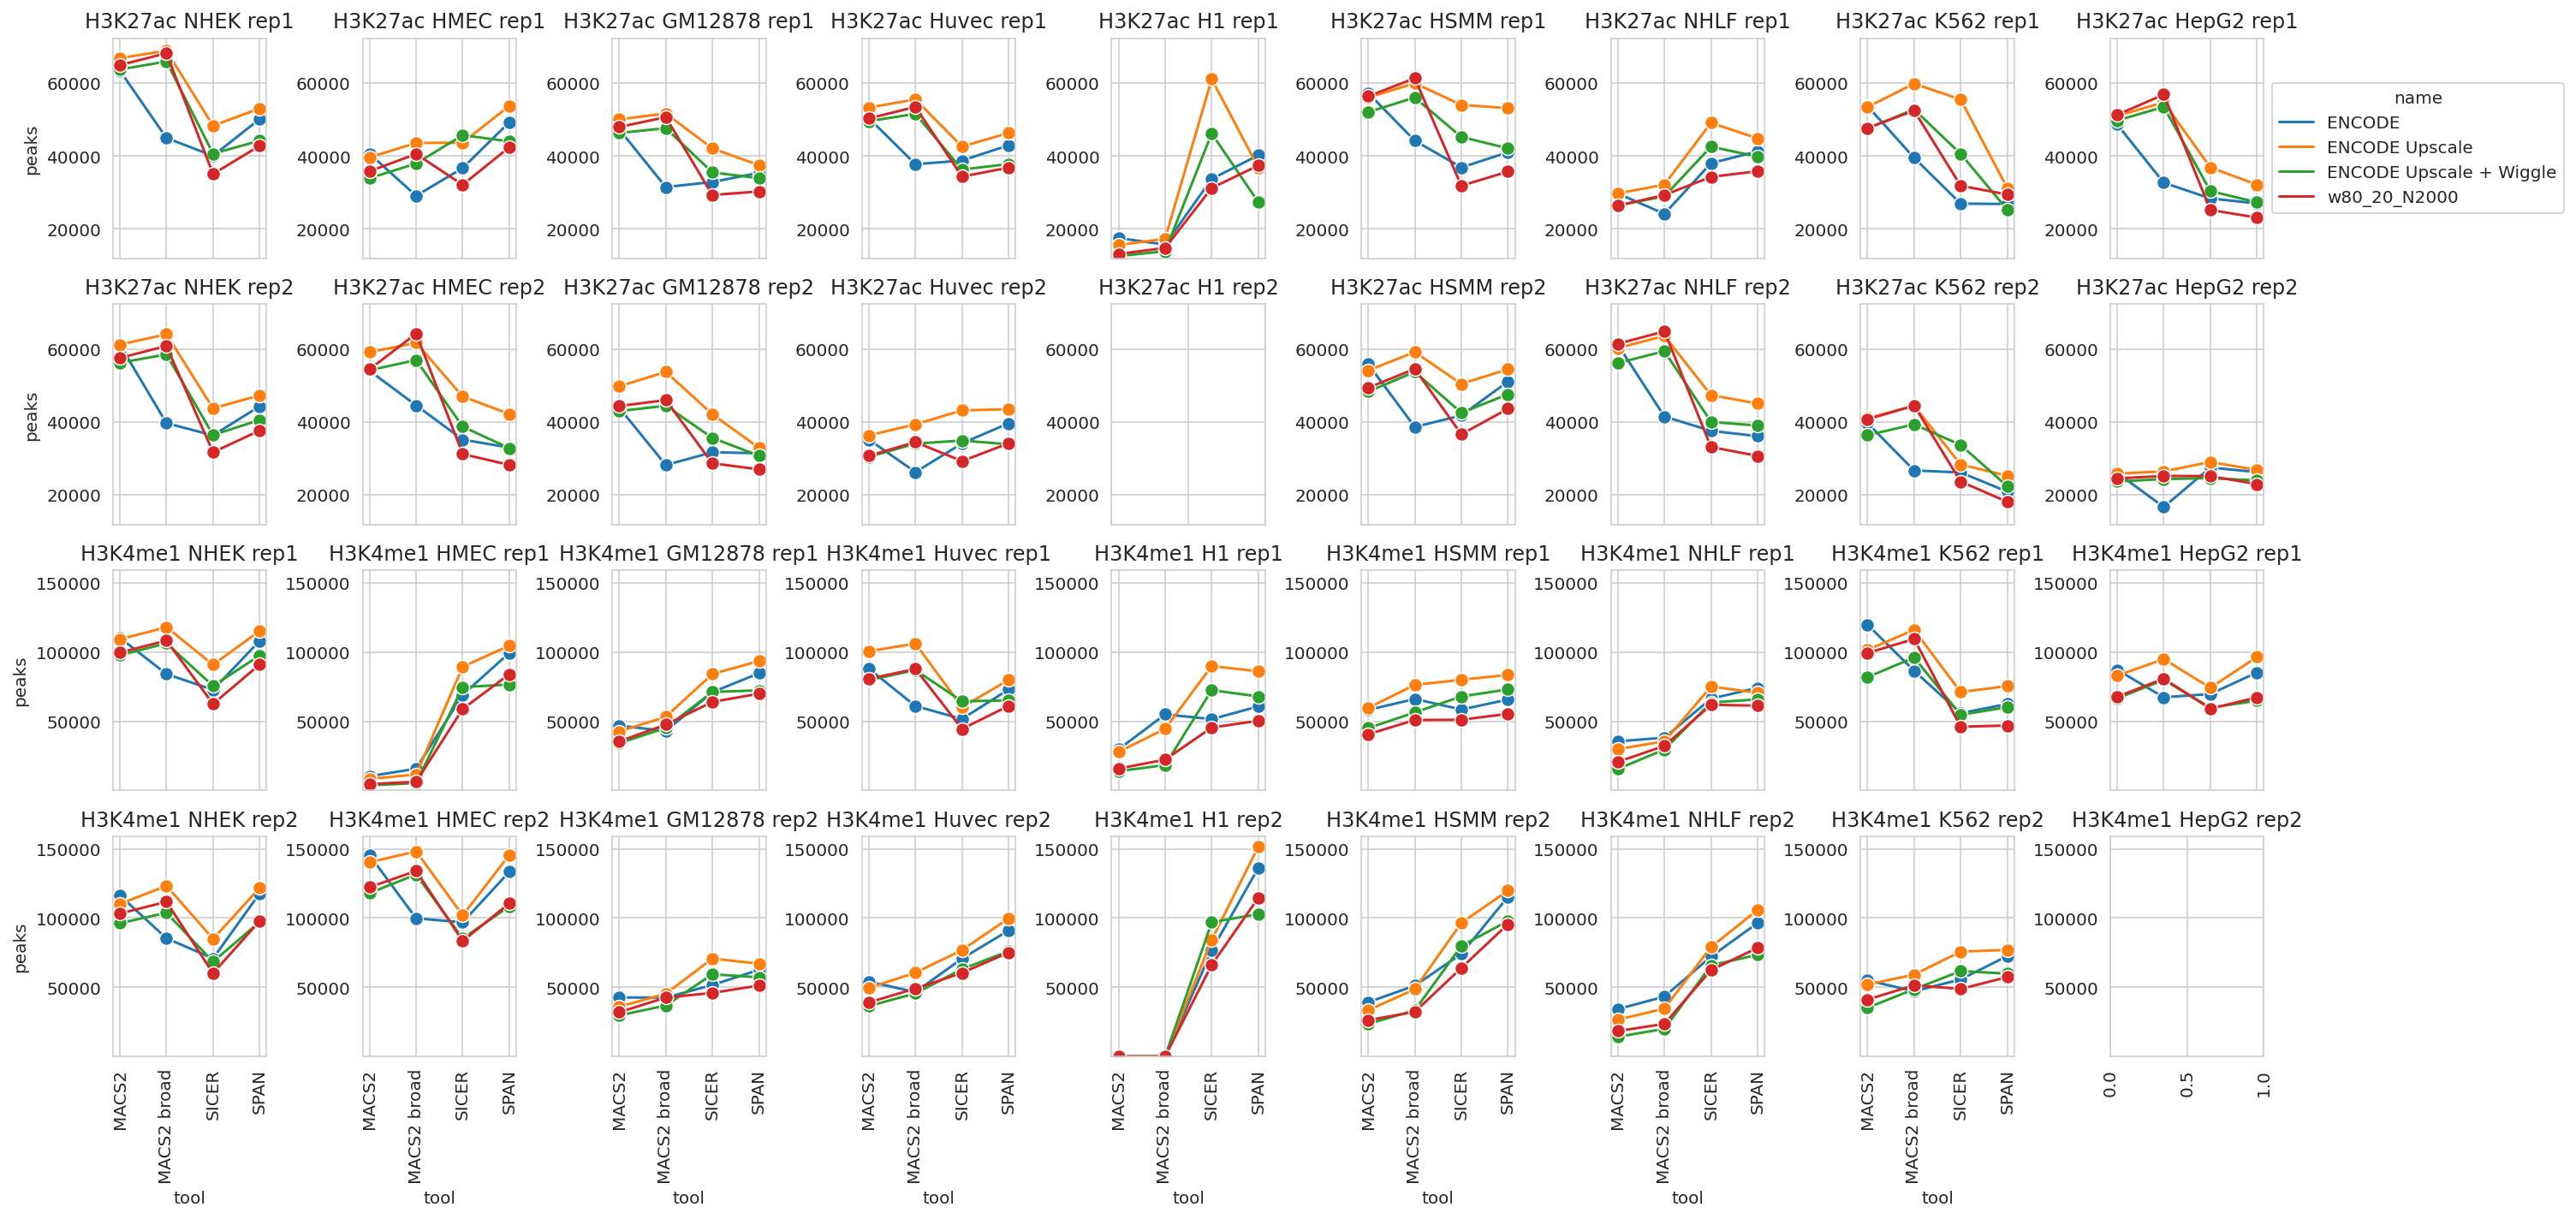

In [80]:
plt.figure(figsize=(21, 10))
CELLS = list(wiggle_mix_peaks['cell'].unique())
# CELLS = ['GM12878', 'K562', 'Huvec'] 
axs = [plt.subplot(4, len(CELLS), i + 1) for i in range(2 * len(CELLS) * 2)]

for i, (m, r, c) in enumerate(product(['H3K27ac', 'H3K4me1'], GSE26320_REPS, CELLS)):
    print(m, c, r)
    ax = axs[i]
    g_results = sns.lineplot(data=wiggle_mix_original_peaks[(wiggle_mix_original_peaks['modification']==m) &
                                                            (wiggle_mix_original_peaks['cell'] == c) &
                                                            (wiggle_mix_original_peaks['replicate'] == r)],
                             x='tool', y='peaks', hue='name',
                             hue_order=list(sorted(wiggle_mix_original_peaks['name'].unique())),
                             ax=ax,
                             # errorbar='se', 
                             marker='o', markersize=8
                             )
    if i + 1 == len(CELLS):
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i % len(CELLS) != 0:
        ax.set_ylabel(None)
    if i < len(CELLS) * 3:
        # ax.set_xticks([], minor=False)
        g_results.axes.set_xticklabels([])   
        ax.set_xlabel(None)
    else:
        ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{m} {c} {r}')
    ax.set_ylim(bottom = 0.95 * wiggle_mix_original_peaks[wiggle_mix_original_peaks['modification']==m]['peaks'].min(),
                top = 1.05 * wiggle_mix_original_peaks[wiggle_mix_original_peaks['modification']==m]['peaks'].max())
plt.tight_layout()
plt.show()

## Peaks lengths

In [81]:
print('Load lengths')
ts = []
for _, (file, m, c, r, ty, tool) in tqdm(
        wiggle_mix_original_peaks[['file', 'modification', 'cell', 'replicate', 'type', 'tool']].iterrows()
):
    # if c in ['H1', 'GM12878', 'HSMM', 'NHLF', 'HMEC']:
    #     continue
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 1000)).copy()
    t['modification'] = m
    t['cell'] = c
    t['replicate'] = r
    t['type'] = ty
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
add_names(t)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

,length,modification,cell,replicate,type,tool,name
152451,230,H3K27ac,K562,rep2,w80_20_N2000,MACS2,w80_20_N2000
98703,12599,H3K27ac,HepG2,rep1,ENCODE,SICER,ENCODE
434158,2599,H3K27ac,HSMM,rep2,w80_20_N2000,SICER,w80_20_N2000
127732,1746,H3K27ac,HSMM,rep2,ENCODE,SPAN,ENCODE
344632,5599,H3K4me1,Huvec,rep1,x2_N10_w80_20_N2000,SICER,ENCODE Upscale + Wiggle
191436,491,H3K4me1,K562,rep2,w80_20_N2000,MACS2,w80_20_N2000
461019,880,H3K4me1,H1,rep1,x2_N10,SPAN,ENCODE Upscale
481588,928,H3K4me1,Huvec,rep2,x2_N10,SPAN,ENCODE Upscale
323230,468,H3K4me1,K562,rep1,x2_N10_w80_20_N2000,MACS2 broad,ENCODE Upscale + Wiggle
154074,298,H3K27ac,NHLF,rep2,x2_N10_w80_20_N2000,MACS2,ENCODE Upscale + Wiggle


H3K27ac MACS2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac MACS2 broad


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac SPAN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac SICER
H3K4me1 MACS2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 MACS2 broad


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 SPAN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1 SICER


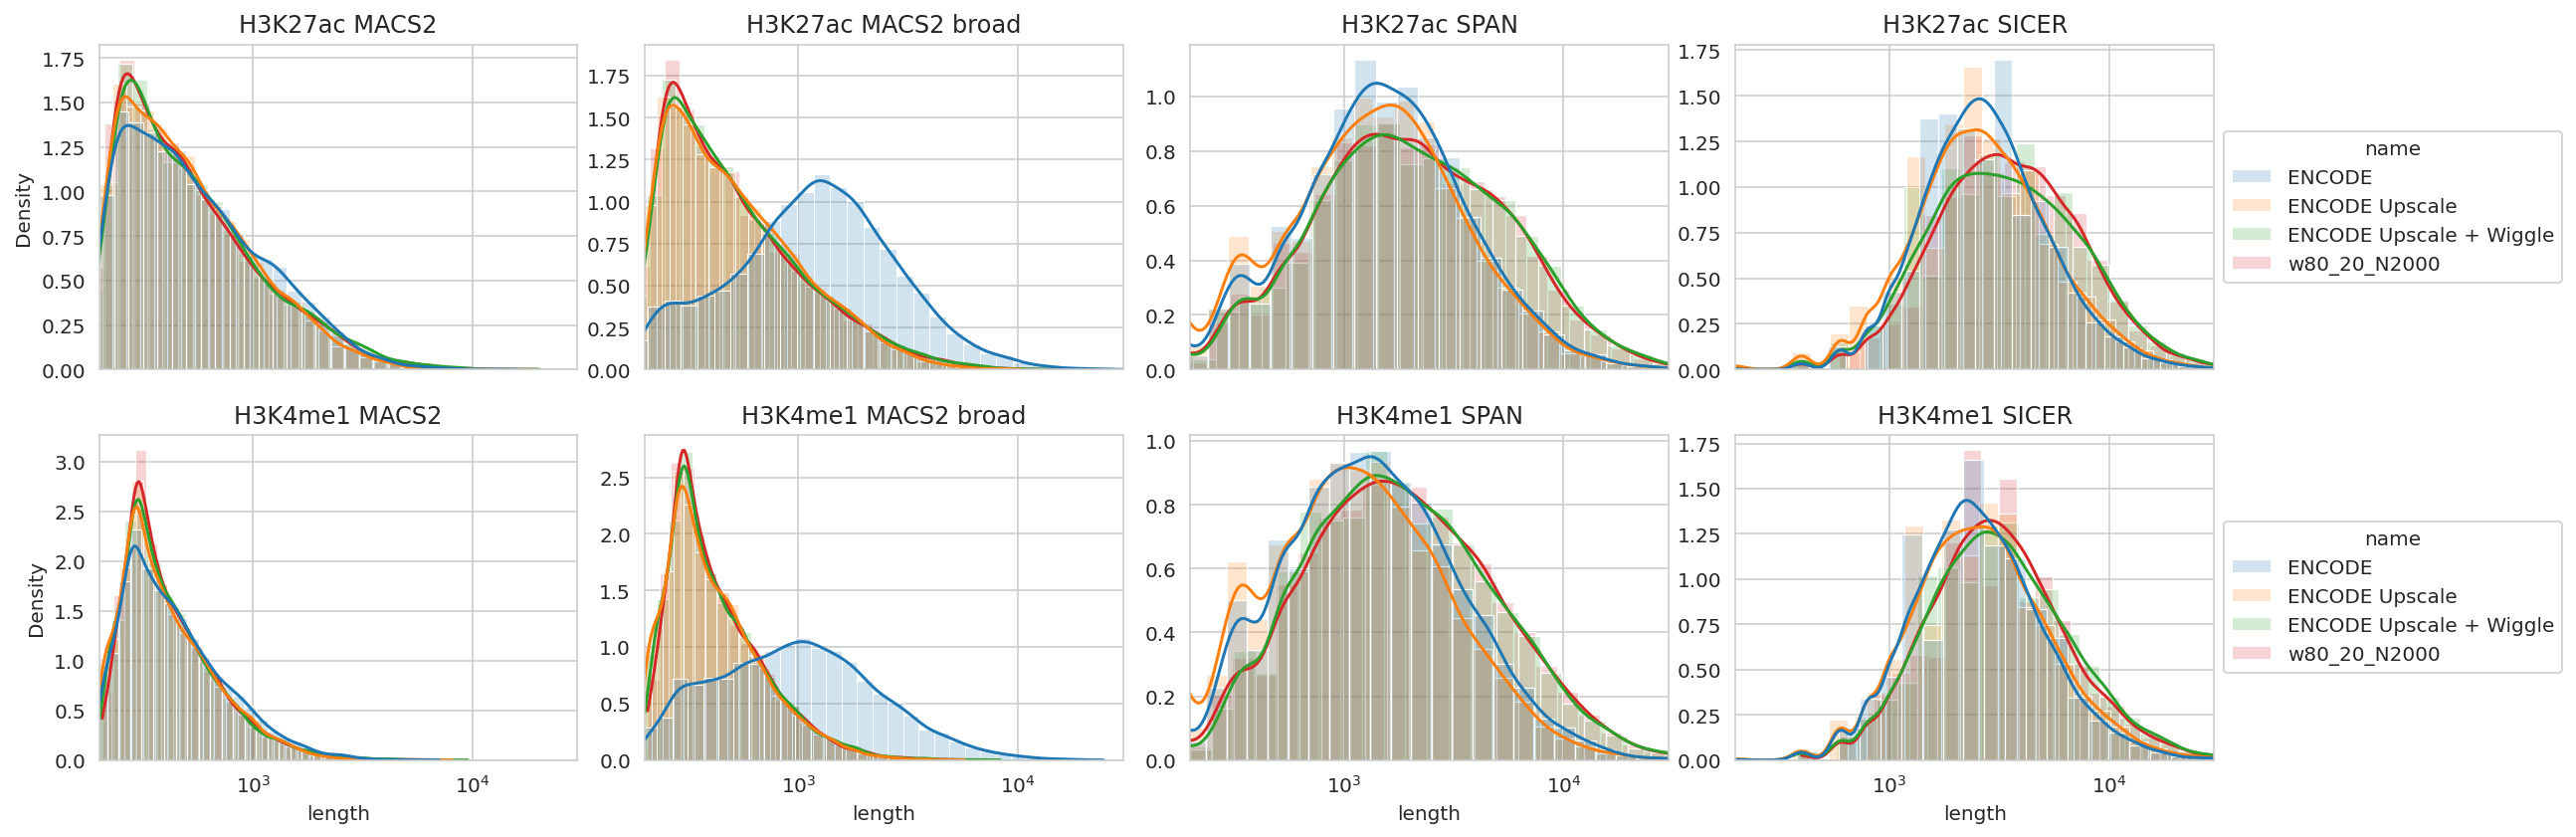

In [82]:
plt.figure(figsize=(18, 6))
CELLS = list(wiggle_mix_peaks['cell'].unique())
axs = [plt.subplot(2, len(TOOLS), i + 1) for i in range(2 * len(TOOLS))]

for i, (m, tool) in enumerate(product(['H3K27ac', 'H3K4me1'], TOOLS)):
    print(m, tool)
    ax = axs[i]
    g_results = sns.histplot(data=t[(t['modification']==m) &
                                    (t['tool'].isin([tool]))],
                             x='length', hue='name',
                             hue_order=list(sorted(t['name'].unique())),
                             ax=ax, stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.2
                             )
    if (i + 1) % len(TOOLS) != 0:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if i % len(TOOLS) != 0:
        ax.set_ylabel(None)
    if i < len(TOOLS):
        # ax.set_xticks([], minor=False)
        g_results.axes.set_xticklabels([])
        ax.set_xlabel(None)
    ax.set_title(f'{m} {tool}')
    ax.set_xlim(2e2, 3e4)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


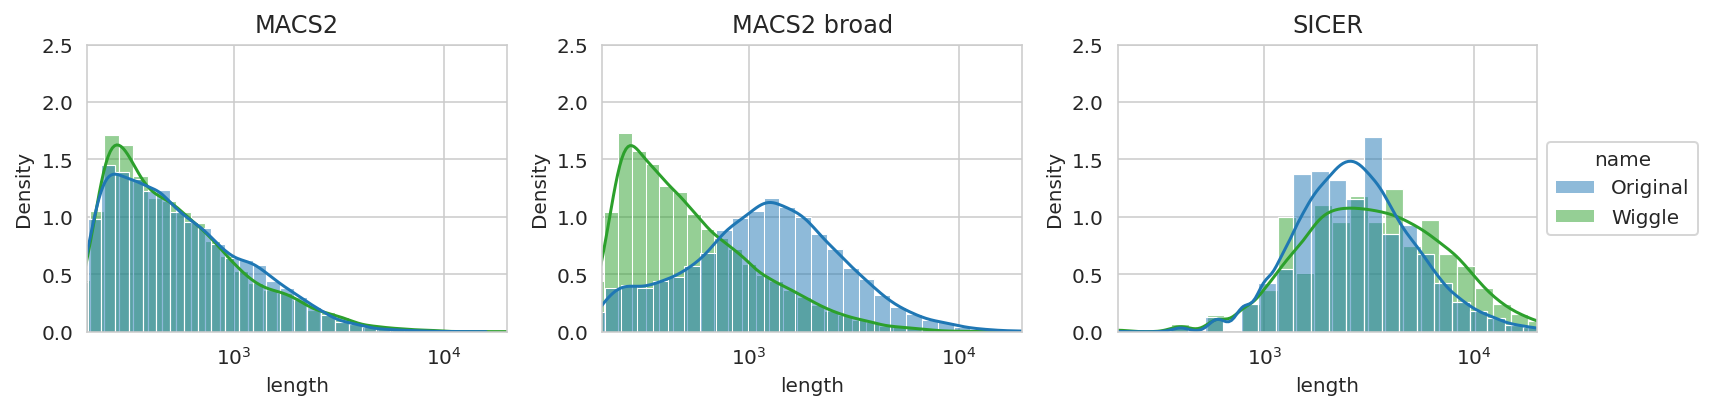

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


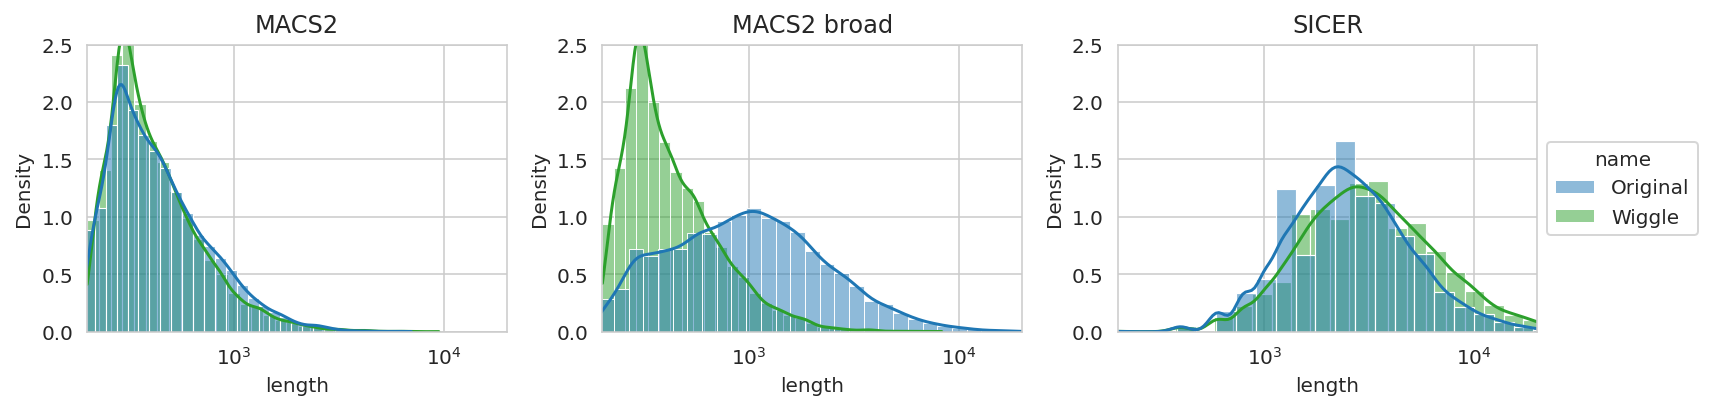

In [83]:
palette = plt.cm.get_cmap('tab10')
PALETTE = {'Original': palette(0), 'Wiggle': palette(2)}

# t['dataset'] = t['modification'] + ' ' + t['reads']
tt = t[t['type'].isin(['ENCODE', 'x2_N10_w80_20_N2000'])].copy()
tt.loc[tt['type'] == 'ENCODE', 'name'] = 'Original'
tt.loc[tt['type'] != 'ENCODE', 'name'] = 'Wiggle'
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=tt[(tt['modification'] == m) & (tt['tool'] == tool)],
                                 x='length', hue='name', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 hue_order=['Original', 'Wiggle'],
                                 palette=PALETTE
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 2e4)
        ax.title.set_text(f'{tool}')
        if i < 2:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


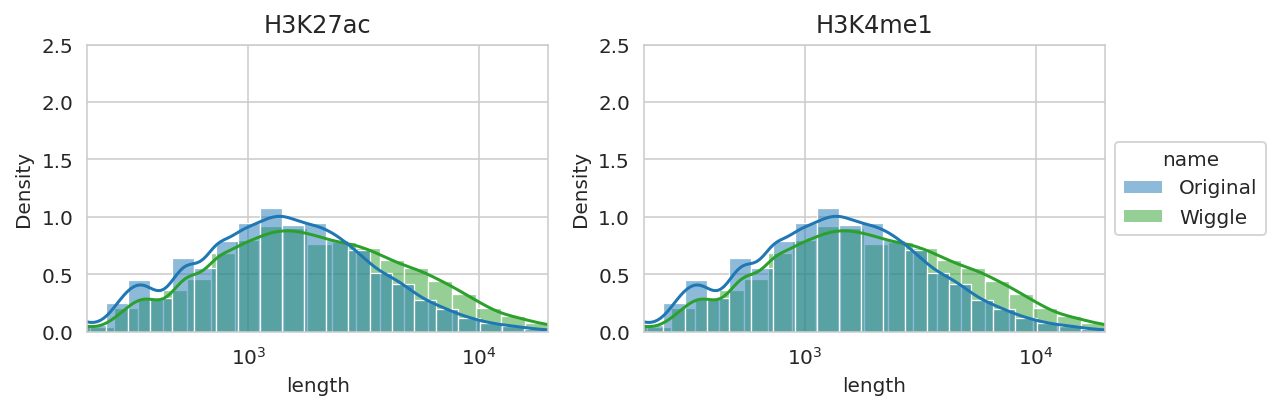

In [84]:
palette = plt.cm.get_cmap('tab10')
PALETTE = {'Original': palette(0), 'Wiggle': palette(2)}

tt = t[t['type'].isin(['ENCODE', 'x2_N10_w80_20_N2000'])].copy()
tt.loc[tt['type'] == 'ENCODE', 'name'] = 'Original'
tt.loc[tt['type'] != 'ENCODE', 'name'] = 'Wiggle'
plt.figure(figsize=(9, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=tt[(tt['tool'] == 'SPAN')],
                             x='length', hue='name', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             hue_order=['Original', 'Wiggle'],
                             palette=PALETTE
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 2.5)
    g_results.set_xlim(200, 2e4)
    ax.title.set_text(f'{m}')
    if i < 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [85]:
t2 = df_peaks[(df_peaks['modification'].isin(['H3K27ac', 'H3K4me1'])) &
              (df_peaks['dataset'] == 'Roadmap') &
              (df_peaks['replicate'] == '')].copy()
t2['scale'] = 2.5
t2['upscale'] = 1.0
t2['wiggle'] = 0.0
t2['type'] = 'Roadmap'

t3 = df_downsample[(df_downsample['reads'] == '10M') & 
                   (df_downsample['modification'].isin(['H3K27ac', 'H3K4me1']))].copy()
t3['scale'] = 2.2
t3['upscale'] = 0.5
t3['wiggle'] = 0.0
t3['type'] = 'Roadmap_10M'

wiggle_mix_original_all_peaks = pd.concat([t2, t3, wiggle_mix_original_peaks]).reset_index(drop=True)

wiggle_mix_original_all_peaks.loc[wiggle_mix_original_all_peaks['type'] == 'Roadmap', 'name'] = 'Roadmap'
wiggle_mix_original_all_peaks.loc[wiggle_mix_original_all_peaks['type'] == 'Roadmap_10M', 'name'] = 'Roadmap Downscale'
wiggle_mix_original_all_peaks

,file,modification,cell,replicate,peaks,tool,dataset,scale,upscale,wiggle,type,quality,reads,name
0,/home/jetbrains/data/2023_Immune/macs2/PBMC_H3...,H3K27ac,PBMC,,36545,MACS2,Roadmap,2.5,1.0,0.0,Roadmap,NaN,NaN,Roadmap
1,/home/jetbrains/data/2023_Immune/macs2/TCell_H...,H3K4me1,TCell,,158205,MACS2,Roadmap,2.5,1.0,0.0,Roadmap,NaN,NaN,Roadmap
2,/home/jetbrains/data/2023_Immune/macs2/NK_H3K2...,H3K27ac,NK,,54313,MACS2,Roadmap,2.5,1.0,0.0,Roadmap,NaN,NaN,Roadmap
3,/home/jetbrains/data/2023_Immune/macs2/Monocyt...,H3K4me1,Monocyte,,124907,MACS2,Roadmap,2.5,1.0,0.0,Roadmap,NaN,NaN,Roadmap
4,/home/jetbrains/data/2023_Immune/macs2/CD34_H3...,H3K4me1,CD34,,153731,MACS2,Roadmap,2.5,1.0,0.0,Roadmap,NaN,NaN,Roadmap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,/home/jetbrains/data/2023_wiggle/span/H3K27ac_...,H3K27ac,HepG2,rep2,26861,SPAN,NaN,2.0,2.0,0.0,x2_N10,NaN,NaN,ENCODE Upscale
603,/home/jetbrains/data/2023_wiggle/span/H3K4me1_...,H3K4me1,HepG2,rep1,64865,SPAN,NaN,2.0,2.0,2000.0,x2_N10_w80_20_N2000,NaN,NaN,ENCODE Upscale + Wiggle
604,/home/jetbrains/data/2023_wiggle/span/H3K27ac_...,H3K27ac,HMEC,rep1,42406,SPAN,NaN,1.0,1.0,2000.0,w80_20_N2000,NaN,NaN,w80_20_N2000
605,/home/jetbrains/data/2023_wiggle/span/H3K4me1_...,H3K4me1,K562,rep2,59854,SPAN,NaN,2.0,2.0,2000.0,x2_N10_w80_20_N2000,NaN,NaN,ENCODE Upscale + Wiggle


# Find bigwigs

In [86]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}


def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [87]:
encode_bws = load_bws(GSE26320_PATH + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
encode_bws['dataset'] = 'ENCODE'
display(encode_bws.sample(3))

immune_bws = load_bws(IMMUNE_PATH + '/bw', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, None)
immune_bws['dataset'] = 'Roadmap'
display(immune_bws.sample(3))

  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate,dataset
6,/home/jetbrains/data/2023_GSE26320/bw/GSM64647...,H3K27me3,NHLF,rep2,ENCODE
58,/home/jetbrains/data/2023_GSE26320/bw/GSM64646...,H3K4me3,NHEK,rep1,ENCODE
25,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,H3K27me3,GM12878,rep2,ENCODE


  0%|          | 0/47 [00:00<?, ?it/s]

,file,modification,cell,replicate,dataset
28,/home/jetbrains/data/2023_Immune/bw/CD34_H3K36...,H3K36me3,CD34,rep1,Roadmap
36,/home/jetbrains/data/2023_Immune/bw/CD4_H3K27a...,H3K27ac,CD4,,Roadmap
35,/home/jetbrains/data/2023_Immune/bw/CD34_H3K4m...,H3K4me1,CD34,rep2,Roadmap


In [88]:
immune_10m_bws = load_bws(IMMUNE_PATH + '_10M/bw', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, None)
immune_10m_bws['dataset'] = 'Roadmap_10M'
display(immune_10m_bws.sample(3))

FileNotFoundError: [Errno 2] No such file or directory: '/home/jetbrains/data/2023_Immune_mln_control/bw'

In [ ]:
wiggle_bws = load_bws(WD + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, None)
wiggle_bws['type'] = [re.sub('.*rep[12]_|\.bw', '', os.path.basename(f)) for f in wiggle_bws['file']]
wiggle_bws['upscale'] = [None if 'x' not in ty else float(re.sub('x|_N.*', '', ty)) for ty in wiggle_bws['type']]
wiggle_bws['wiggle'] = [None if 'w' not in ty else int(re.sub('.*_N', '', ty)) for ty in wiggle_bws['type']]

wiggle_bws.sample(5)

In [ ]:
t = wiggle_bws.copy()
t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
t['scale'] = t['upscale']
t2 = encode_bws[(encode_bws['modification'].isin(['H3K27ac', 'H3K4me1'])) & 
                (encode_bws['cell'].isin(CELLS)) 
].copy()
t2['scale'] = 0.5
t2['wiggle'] = 0.0
t2['type'] = 'ENCODE'

t3 = immune_bws[immune_bws['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t3['scale'] = 2.5
t3['wiggle'] = 0.0
t3['type'] = 'Roadmap'

t4 = immune_10m_bws[immune_10m_bws['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
t4['scale'] = 2.2
t4['wiggle'] = 0.0
t4['type'] = 'Roadmap_10M'

all_bws = pd.concat([t, t2, t3, t4]).reset_index(drop=True)
all_bws = all_bws.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in all_bws[['modification', 'cell', 'replicate']].iterrows()]].copy()
all_bws.sample(5)

In [ ]:
add_names(all_bws)

## Prepare homemade BigWig based peaks

In [ ]:
import math
import pyBigWig

def bw_peak_calling(bw_path, chrom_sizes, blacklist, bin, top_bins, merge=False):
    print('Prepare chromosome indexes')
    chr_indx = {}
    indx = 0
    for chr, chr_size in chrom_sizes.items():
        if '_' in chr:
            continue
        bins = int(math.floor(chr_size / bin))
        chr_indx[chr] = (indx, indx + bins)
        indx += bins
    chromosomes = list(chr_indx.keys())
    # print(chromosomes)
    # print(chr_indx)

    print('Compute binned coverage')    
    binned_coverage = np.zeros(indx)
    with pyBigWig.open(bw_path) as bw:
        for chr, (istart, iend) in chr_indx.items():
            binned_coverage[istart: iend] =\
                np.array([x or 0 for x in bw.stats(chr, 1, CHROM_SIZES[chr], nBins=iend - istart, exact=True, type='sum')])
    
    if blacklist is not None:
        print('Processing blacklisted regions')
        blacklist_marked = 0
        for chr, start, end in zip(blacklist['chr'], blacklist['start'], blacklist['end']):
            if chr not in chr_indx:
                continue
            offset = chr_indx[chr][0]
            for x in range(int(math.floor(start / bin)), int(math.ceil(end / bin)) + 1):
                binned_coverage[min(x - offset, len(binned_coverage) - 1)] = 0
                blacklist_marked += 1
        print(f'Marked {blacklist_marked} / {len(binned_coverage)} bins as blacklist')
    
    print('Total coverage', binned_coverage.sum())
    print('Split by chromosomes')
    if top_bins > len(binned_coverage):
        raise Exception(f'Too many top bins {top_bins} > {len(binned_coverage)}')
    chr_xs = [[] for _ in range(len(chr_indx))]  # Create new array for each chromosome index
    ichr = 0
    for x in np.sort(np.argpartition(binned_coverage, -top_bins)[-top_bins:]):
        while chr_indx[chromosomes[ichr]][1] < x:
            ichr += 1
        chr_xs[ichr].append(x)
    # print(chr_xs)

    print('Collect final peaks')
    peaks = []
    for ichr, xs in enumerate(chr_xs):
        chr = chromosomes[ichr]
        offset = chr_indx[chr][0]
        if merge:
            start = -1
            sum_coverage = 0
            for i, x in enumerate(xs):
                if i == 0:
                    start = x
                    sum_coverage = 0
                elif xs[i - 1] != x - 1:
                    peaks.append((chr, (start - offset) * bin, (xs[i - 1] + 1 - offset) * bin, sum_coverage))
                    start = x
                    sum_coverage = binned_coverage[x]
                else:
                    sum_coverage += binned_coverage[x]
            peaks.append((chr, (start - offset) * bin, (xs[-1] + 1 - offset) * bin, sum_coverage))
        else:
            for i, x in enumerate(xs):
                peaks.append((chr, (x - offset) * bin, (x + 1 - offset) * bin, binned_coverage[x])) 
    return pd.DataFrame(peaks, columns=['chromosome', 'start', 'end', 'coverage'])

## Black lists
https://github.com/Boyle-Lab/Blacklist/tree/master/lists

In [ ]:
BLACKLIST_PATH = WD + '/hg38-blacklist.v2.bed'
blacklist_df = pd.read_csv(BLACKLIST_PATH, sep='\t', header=None)
blacklist_df.rename({0: 'chr', 1: 'start', 2: 'end'}, axis=1, inplace=True)
blacklist_df

In [ ]:
# bw_path = '/home/jetbrains/data/2023_GSE26320/bw/GSM646394_HSMM_H3K27ac_rep1.bw'
# bin = 5_000
# top_bins = 25_000
# chrom_sizes_2 = {'chr1': CHROM_SIZES['chr1'], 'chr2': CHROM_SIZES['chr2']}
# 
# print('WITHOUT BLACKLIST')
# display(bw_peak_calling(bw_path, chrom_sizes_2, None, bin, top_bins))
# 
# print('WITH BLACKLIST')
# display(bw_peak_calling(bw_path, chrom_sizes_2, blacklist_df, bin, top_bins))

In [ ]:
chrom_sizes_3 = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

BIN = 10_000
NBINS = 50_000
MERGE = False
HMD = f'{WD}/homemade_{BIN}bp_{NBINS}_{MERGE}'
print(HMD)
! mkdir -p {HMD}

for _, (m, c, r, ty) in tqdm(list(all_bws[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows())):
    print(m, c, r, ty)
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['type'] == ty)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    print(bw_path)
    peaks_path = f'{WD}/homemade_{BIN}bp_{NBINS}_{MERGE}/{m}_{c}_{r}_{ty}.bed'
    print(peaks_path)
    if os.path.exists(peaks_path):
        continue
    peaks = bw_peak_calling(bw_path, chrom_sizes_3, blacklist_df, BIN, NBINS, merge=MERGE)
    peaks.to_csv(peaks_path, sep='\t', header=False, index=None)

# Compute roughness

In [ ]:
from scipy.stats import zscore

def ra(xs):
    zs = xs - np.mean(xs)
    return np.fabs(zs).sum() / len(xs) 

def rq(xs):
    zs = xs - np.mean(xs)
    return math.sqrt((zs * zs).sum() / len(xs)) 

xs = [3,6,20,13,7,15,12,15,7,2]
print('RQ', rq(xs))
print('RA', ra(xs))

ys = [3,8,17,14,8,13,12,16,6,3]
print('RQ', rq(ys))
print('RA', ra(ys))


In [ ]:
from math import ceil
import pyBigWig

def compute_roughness(bw_path, chrom_sizes, bin, m, c, r, ty, peaks_path=None, peaks=1000):
    if bin < 50:
        raise Exception('Too small bin size')
    rows = []
    try:
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in chrom_sizes.keys() if '_' not in chr) / 1e6
            print('Total coverage', total_coverage)
            if peaks_path is None or not os.path.exists(peaks_path):
                print('Computing roughness on chromosomes 10k-10mln')
                # TODO: process black listed regions here!!!
                for chr, chr_size in chrom_sizes.items():
                    chr_size = min(10_000_000, chr_size)
                    stats = np.array(bw.stats(chr, 100_000, chr_size, nBins=int(ceil((chr_size - 100_000) / bin)), exact=True, type='sum'))
                    rows.append((m, c, r, ty, total_coverage, f'{chr}:100000-{chr_size}', ra(stats), rq(stats)))
            else:
                print(f'Computing roughness on peaks file {peaks_path}')
                t = pd.read_csv(peaks_path, sep='\t', header=None)
                if len(t) > peaks:
                    print(f'Pick {peaks} uniform peaks for computation speedup')
                    step = int(math.ceil(len(t) / float(peaks)))
                    idxs = [False] * len(t) 
                    for i in range(0, len(t), step):
                        idxs[i] = True
                    print(sum(idxs))
                    t = t.loc[idxs].copy()  
                for chr, start, end in zip(t[0], t[1], t[2]):
                    if chr in chrom_sizes:
                        stats = np.array(bw.stats(chr, start, end, nBins=int(ceil((end - start) / bin)), exact=True, type='sum'))
                        rows.append((m, c, r, ty, f'{chr}:{start}-{end}', np.mean(stats), ra(stats), rq(stats)))
    except Exception as e:
        print(e)
        pass  # Ignore

    df_roughness = pd.DataFrame(rows,
                                columns=['modification', 'cell', 'replicate', 'type', 'position', 'mean', 'ra', 'rq'])
    return total_coverage, df_roughness

In [ ]:
ROUGHNESS_BIN = 100  # Should be bigger than used for upscaling (N10) and resolution of bigwig file (50bp)!
ROUGHNESS_PEAKS = 1000
chrom_sizes_3 = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

total_coverages = {}
ts = []
for _, (m, c, r, ty) in tqdm(list(all_bws[['modification', 'cell', 'replicate', 'type']].drop_duplicates().iterrows())):
    print(m, c, r, ty)
    # if ty not in ['ENCODE', 'Roadmap', 'x2_N10_w80_20_N2000']:  # Ignore others
    #     continue
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['type'] == ty)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    print(bw_path)
    peaks_path = f'{WD}/homemade_{BIN}bp_{NBINS}_{MERGE}/{m}_{c}_{r}_{ty}.bed'
    # peaks_path = f'{WD}/union/{m}_{c}_{r}_{ty}.bed'
    # 100 for speed
    total_coverage, rdf = compute_roughness(bw_path, chrom_sizes_3, ROUGHNESS_BIN, m, c, r, ty, peaks_path=peaks_path,
                                            peaks=ROUGHNESS_PEAKS)
    # We scale coverage to match exact number of reads
    total_coverages[(m, c, r, ty)] = total_coverage * 1e6 / 21
    ts.append(rdf)  
    # ts.append(compute_roughness(bw_path, chrom_sizes_3, ROUGHNESS_BIN, m, c, r, ty, peaks_path=None))
    
df_roughness = pd.concat(ts).reset_index(drop=True)
del ts
df_roughness.sample(5)

In [ ]:
from datetime import datetime
now = datetime.now().isoformat(timespec='minutes')
rfile = f'{WD}/roughness_{BIN}bp_{NBINS}_{ROUGHNESS_BIN}_{ROUGHNESS_PEAKS}_{now}.csv.gz'
# rfile = f'{WD}/roughness_{BIN}bp_10k10m_{now}.csv.gz'
print(rfile)
df_roughness.to_csv(rfile, compression='gzip', index=None)

In [ ]:
# Assign groups by coverage percentiles individually in each track
ts = []
for (m, c, r, ty), group in df_roughness.groupby(['modification', 'cell', 'replicate', 'type']):
    group = group.sort_values(by=['mean'], ascending=False)
    group['percentile'] = [10 * int(10.0 * i / len(group)) for i in range(len(group))]
    group['rpkm'] = group['mean'] / ((total_coverages[(m, c, r, ty)] / 1.e6) * (BIN / 1e3))
    group['rpk'] = group['mean'] / (BIN / 1e3) 
    ts.append(group)
df_roughness = pd.concat(ts).reset_index(drop=True)
del ts
df_roughness.sample(5)

In [ ]:
t = df_roughness[
    ['modification', 'cell', 'replicate', 'type', 'name', 'percentile', 'rpk', 'rpkm', 'r']
].groupby(['modification', 'cell', 'replicate', 'type', 'name', 'percentile']).agg('mean').reset_index()
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(
        data=t[(t['modification'] == m)],
        x='percentile', y='rpkm', hue='name',
        hue_order=['ENCODE', 'ENCODE Upscale + Wiggle', 'Roadmap'],
        ax=ax)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

## Peaks per percentiles - analyze number of overlapping peaks by coverage / roughness

In [ ]:
tf = tempfile.mktemp()
tf2 = tempfile.mktemp()
rows = []
peaks = {tool: [] for tool in TOOLS}
for (m, c, r, ty, perc), group in tqdm(df_roughness.groupby(['modification', 'cell', 'replicate', 'type', 'percentile'])):
    if ty not in ['ENCODE', 'Roadmap', 'x2_N10_w80_20_N2000']:  # Ignore others
        continue    
    print(m, c, r, ty, perc)
    t = pd.DataFrame([re.split('[\\:\\-]', pos) for pos in group['position']], columns=['chr', 'start', 'end'])
    t.to_csv(tf, sep='\t', index=False, header=None)
    tf = sorted_file(tf)
    for tool in TOOLS:
        t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['modification'] == m) &
                                          (wiggle_mix_original_all_peaks['cell'] == c) &
                                          (wiggle_mix_original_all_peaks['replicate'] == r) &
                                          (wiggle_mix_original_all_peaks['type'] == ty) &
                                          (wiggle_mix_original_all_peaks['tool'] == tool)]
        if len(t) == 0:
            continue        
        tool_file = sorted_file(t['file'].values[0])
        perc_peaks, perc_len = lines(tf), bedl(tf).sum()
        tool_peaks, tool_len = lines(tool_file), bedl(tool_file).sum()
        !bedtools intersect -a {tf} -b {tool_file} -wa -u > {tf2}
        overlap1 = lines(tf2)
        !bedtools intersect -b {tf} -a {tool_file} -wa -u > {tf2}
        overlap2 = lines(tf2)
        !bedtools intersect -a {tf} -b {tool_file} -wo > {tf2}
        overlap_len = int(last_col(tf2).sum())
        rows.append((m, c, r, ty, perc, tool, perc_peaks, perc_len, tool_peaks, tool_len, overlap1, overlap2, overlap_len))

df_perc_peaks = pd.DataFrame(rows, columns=[
    'modification', 'cell', 'replicate', 'type', 'percentile', 'tool',
    'perc_peaks', 'perc_len', 'tool_peaks', 'tool_len', 'overlap1', 'overlap2', 'overlap_len'
])
del rows
df_perc_peaks.sample(5)

In [ ]:
from datetime import datetime
now = datetime.now().isoformat(timespec='minutes')
rfile = f'{WD}/perc_peaks_{BIN}bp_{NBINS}_{now}.csv.gz'
print(rfile)
df_perc_peaks.to_csv(rfile, compression='gzip', index=None)

In [ ]:
add_names(df_perc_peaks)
df_perc_peaks['perc_avg_bins'] = df_perc_peaks['perc_len']  / df_perc_peaks['perc_peaks'] / BIN
df_perc_peaks['peaks_per_perc'] = (df_perc_peaks['overlap2'] / df_perc_peaks['tool_peaks']) / df_perc_peaks['perc_avg_bins']

for tool in TOOLS:
    print(tool)
    plt.figure(figsize=(12, 4))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        ax = axs[i]
        g_results = sns.boxplot(
            data=df_perc_peaks[(df_perc_peaks['modification'] == m) & 
                               (df_perc_peaks['tool'] == tool)],
            x='percentile', y='overlap2', hue='name',
            hue_order=['ENCODE', 'ENCODE Upscale + Wiggle', 'Roadmap'],
            ax=ax, showfliers=False)
        # ax.set(yscale='log')
        ax.title.set_text(f'{m} {tool}')
        ax.set_ylabel('Peaks in coverage percentile')
        if i == 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    plt.show()

## Roughness vs coverage percentile 

In [ ]:
add_names(df_roughness)

In [ ]:
def plot_modifications_simple(df, X, Y, text=False):
    plt.figure(figsize=(11, 4))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        ax = axs[i]
        t = df[df['modification'] == m].copy()
        sns.scatterplot(data=t,
                        x=X, y=Y, hue='name',
                        hue_order=sorted(t['name'].unique()),
                        alpha=0.5,
                        ax=ax)
        if text:
            for x, y, cell, rep in zip(t[X], t[Y], t['cell'], t['replicate']):
                ax.text(x, y, f'{cell} {rep}', fontsize = 4)
        ax.title.set_text(m)
        if i == 1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_modifications_simple(df_roughness, 'rq', 'ra', text=False)

In [ ]:
df_roughness['ran'] = [ra / total_coverages[(m, c, r, ty)] for _, (m, c, r, ty, ra) in 
                       df_roughness[['modification', 'cell', 'replicate', 'type', 'ra']].iterrows()]
df_roughness['rqn'] = [rq / total_coverages[(m, c, r, ty)] for _, (m, c, r, ty, rq) in
                       df_roughness[['modification', 'cell', 'replicate', 'type', 'rq']].iterrows()]
df_roughness['ran2'] = df_roughness['ra'] / df_roughness['mean']
df_roughness['rqn2'] = df_roughness['rq'] / df_roughness['mean']
df_roughness['meann'] = [mean / total_coverages[(m, c, r, ty)] for _, (m, c, r, ty, mean) in
                       df_roughness[['modification', 'cell', 'replicate', 'type', 'mean']].iterrows()]
df_roughness['r'] = df_roughness['rqn2']

In [ ]:
plot_modifications_simple(df_roughness.sample(frac=1).reset_index(drop=True), 'rqn2', 'meann', text=False)

In [ ]:
df_roughness['cell_rep'] = df_roughness['cell'] + ' ' + df_roughness['replicate']

plt.figure(figsize=(22, 8))
CELLS = list(wiggle_mix_peaks['cell'].unique())
NAMES = len(df_roughness['name'].unique())
axs = [plt.subplot(2, NAMES, i + 1) for i in range(2 * NAMES)]

for i, (m, name) in enumerate(product(['H3K27ac', 'H3K4me1'], df_roughness['name'].unique())):
    print(m, name)
    ax = axs[i]
    g_results = sns.histplot(data=df_roughness[(df_roughness['modification']==m) & (df_roughness['name']==name)],
                             x='r', hue='cell_rep',
                             hue_order=list(sorted(df_roughness['cell_rep'].unique())),
                             ax=ax, stat='density', common_bins=False, common_norm=False,
                             bins=50, kde=True, alpha=0.2
                             )
    if (i + 1) == 7:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i % 7 != 0:
        ax.set_ylabel(None)
    if i < 7:
        # ax.set_xticks([], minor=False)
        # g_results.axes.set_xticklabels([])
        ax.set_xlabel(None)
    ax.set_title(f'{m} {name}')
    ax.set_xlim(0, 5)
plt.tight_layout()
plt.show()

# Aggregate roughness by sample

In [ ]:
t = df_roughness[
    ['modification', 'cell', 'replicate', 'type', 'name', 'percentile', 'r']
].groupby(['modification', 'cell', 'replicate', 'type', 'name', 'percentile']).agg('mean').reset_index()
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(
        data=t[(t['modification'] == m)],
        x='percentile', y='r', hue='name',
        # hue_order=['ENCODE', 'Roadmap', 'Roadmap Downscale', 'ENCODE Wiggle', 'ENCODE Upscale',
        #            'ENCODE Upscale + Wiggle', 'ENCODE Upscale + Wiggle 2'],
        hue_order=['ENCODE', 'ENCODE Upscale + Wiggle', 'Roadmap'],
        ax=ax)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
t = df_roughness[
    ['modification', 'cell', 'replicate', 'type', 'name', 'percentile', 'r']
].groupby(['modification', 'cell', 'replicate', 'type', 'name', 'percentile']).agg('mean').reset_index()
plt.figure(figsize=(4, 6))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    g_results = sns.boxplot(data=t[(t['modification'] == m)],
                            x='name', y='r',
                            order=['ENCODE', 'ENCODE Upscale + Wiggle', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    ax.title.set_text(m)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
# df_roughness_aggr = df_roughness[df_roughness['percentile'].isin([0, 10, 20, 30, 40])][
df_roughness_aggr = df_roughness[
    ['modification', 'cell', 'replicate', 'type', 'name', 'ra', 'rq', 'r']
].groupby(['modification', 'cell', 'replicate', 'type', 'name']).agg('mean').reset_index()

df_roughness_aggr['coverage'] = [total_coverages[(m, c, r, ty)] for _, (m, c, r, ty) in 
                                 df_roughness_aggr[['modification', 'cell', 'replicate', 'type']].iterrows()]
df_roughness_aggr.sample(3)

## Additional annotation

In [ ]:
# t = df_wiggle_bams.copy()
# t.fillna(value={'upscale': 1.0, 'wiggle': 0.0}, inplace=True)
# # t['scale'] = t['upscale']
# 
# t2 = df_bams[df_bams['modification'].isin(['H3K27ac', 'H3K4me1'])].copy()
# t2['type'] = t2['dataset']
# t2['scale'] = [0.5 if ds == 'ENCODE' else 2.5 for ds in t2['dataset']]
# t2['wiggle'] = 0.0
# 
# t3 = df_immune_10m_bams.copy()
# t3['type'] = 'Roadmap_10M'
# t3['scale'] = 2.2
# t3['wiggle'] = 0.0
# 
# all_bams_df = pd.concat([t, t2, t3]).reset_index(drop=True)
# all_bams_df

In [ ]:
# reads = []
peaks = {tool: [] for tool in TOOLS}
for _, (m, c, r, ty) in df_roughness_aggr[['modification', 'cell', 'replicate', 'type']].iterrows():
    # t = all_bams_df[(all_bams_df['modification'] == m) & 
    #                 (all_bams_df['cell'] == c) & 
    #                 (all_bams_df['replicate'] == r) & 
    #                 (all_bams_df['type'] == ty)]
    # if len(t) == 0:
    #     reads.append(None)
    # else:
    #     reads.append(t['reads'].values[0])
    for tool in TOOLS:
        t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['modification'] == m) &
                                          (wiggle_mix_original_all_peaks['cell'] == c) &
                                          (wiggle_mix_original_all_peaks['replicate'] == r) &
                                          (wiggle_mix_original_all_peaks['type'] == ty) &
                                          (wiggle_mix_original_all_peaks['tool'] == tool)]
        if len(t) == 0:
            peaks[tool].append(None)
        else:
            peaks[tool].append(t['peaks'].values[0])
        

# df_roughness_aggr['reads'] = reads
for tool in TOOLS:
    df_roughness_aggr[tool] = peaks[tool]

df_roughness_aggr.sample(5)

In [ ]:
df = df_roughness_aggr
X='r'
Y='coverage'

plt.figure(figsize=(8, 4))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df[(df['modification'] == m) & (df['type'].isin(['Roadmap', 'ENCODE']))].copy()
    colors = ['blue' if ty == 'ENCODE' else 'brown' for ty in t['type']]
    sns.scatterplot(data=t,
                    x=X, y=Y,
                    color=colors,
                    alpha=0.8,
                    ax=ax)
    for x, y, cell, rep in zip(t[X], t[Y], t['cell'], t['replicate']):
        ax.text(x, y, f'{cell} {rep}', fontsize = 4)
    for _, (cell, ty) in t[['cell', 'type']].drop_duplicates().iterrows():
        tr = t[(t['cell'] == cell) & (t['type'] == ty)]
        reps = list(tr['replicate'].unique())
        if len(tr) > 1:
            for j in range(len(reps)):
                tj = tr[tr['replicate'] == reps[j]]
                for k in range(j + 1, len(reps)):
                    tk = tr[tr['replicate'] == reps[k]]
                    sns.lineplot(x=[tj[X].values[0], tk[X].values[0]],
                                 y=[tj[Y].values[0], tk[Y].values[0]], color='black', ax=ax, alpha=0.5, linestyle='dotted')

    ax.title.set_text(f'{m} replicates')

plt.tight_layout()
plt.show()

## Visualization

In [ ]:
def plot_wiggle_dataset(df, X, Y, big, texts, 
                        textcenter=True, colorcol=None, x0line=False, y0line=False,
                        links={'red': [('Roadmap', 'Roadmap_10M')],
                               'green':[('ENCODE', 'x2_N10')],
                               'blue': [('ENCODE', 'w80_20_N5000'), ('x2_N10', 'x2_N10_w80_20_N2000'), ('ENCODE', 'w100_100_N2000')]}, 
                        figsizex=11, figsizey=4,
                        margin=0):
    sns.set_style("white")
    plt.figure(figsize=(figsizex, figsizey))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        ax = axs[i]
        t = df[df['modification'] == m].copy()
        t['size'] = [2 if ty in big else 1 for ty in t['name']]

        for _, (c, r) in t[['cell', 'replicate']].drop_duplicates().iterrows():
            for color, color_links in links.items():
                for (s, e) in color_links:
                    p1 = t[(t['cell'] == c) & (t['replicate'] == r) & (t['type'] == s)]
                    p2 = t[(t['cell'] == c) & (t['replicate'] == r) & (t['type'] == e)]
                    if len(p1) == 0 or len(p2) == 0:
                        continue
                    p1x = p1[X].values[0]
                    p1y = p1[Y].values[0]
                    p2x = p2[X].values[0]
                    p2y = p2[Y].values[0]
                    sns.lineplot(x=[p1x, p2x], y=[p1y, p2y], color=color, ax=ax, alpha=0.5, linestyle='dotted')
        
        if colorcol is None:
            sns.scatterplot(data=t,
                            x=X, y=Y, hue='name', ax=ax, size='size',
                            hue_order=sorted(df['name'].unique()), alpha=0.8)
        else:
            sns.scatterplot(data=t,
                            x=X, y=Y, hue=colorcol, palette='Blues', ax=ax, size='size')

        for x, y, cell, replicate, ty in zip(t[X], t[Y], t['cell'], t['replicate'], t['name']):
            if ty in texts and (textcenter or (math.fabs(x) > 1e-3 or math.fabs(y) > 1e-3)):
                ax.text(x, y, f'{cell} {replicate}', fontsize = 5)
                
        if x0line:
            sns.lineplot(x=[0, 0], y=[t[Y].min(), t[Y].max()], color='black', ax=ax, alpha=0.5, linestyle='dotted')
        if y0line:
            sns.lineplot(x=[t[X].min(), t[X].max()], y=[0, 0], color='black', ax=ax, alpha=0.5, linestyle='dotted')

        ax.title.set_text(m)
        if i == 1:
            handles, labels = ax.get_legend_handles_labels()
            # Hide name and size
            ax.legend(handles=handles[1:-(1+len(t['size'].unique()))], labels=labels[1:-(1+len(t['size'].unique()))])
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)
        if margin > 0:
            ax.set_xlim(t[X].min() - (t[X].max() - t[X].min()) * margin, t[X].max() + (t[X].max() - t[X].min()) * margin)
            ax.set_ylim(t[Y].min() - (t[Y].max() - t[Y].min()) * margin, t[Y].max() + (t[Y].max() - t[Y].min()) * margin)

    plt.tight_layout()
    plt.show()
    sns.set_style("whitegrid")

In [ ]:
print('Modification scheme')

X = 'r'
Y = 'coverage'
big = ['Roadmap', 'ENCODE']
texts = ['Roadmap', 'ENCODE']

plot_wiggle_dataset(df_roughness_aggr, X, Y, big, texts, True)


In [ ]:
print('Modification scheme')

X = 'r'
Y = 'coverage'
big = ['Roadmap', 'ENCODE']
texts = ['Roadmap', 'ENCODE']
t = df_roughness_aggr[df_roughness_aggr['type'].isin(['Roadmap', 'ENCODE', 'x2_N10', 'x2_N10_w80_20_N2000'])].copy()
plot_wiggle_dataset(t, X, Y, big, texts, True)

In [ ]:
# Find samples with roughness higher than in Roadmap
SAMPLES = {}
for m in ['H3K27ac', 'H3K4me1']:
    SAMPLES[m] = []
    roadmap_threshold = df_roughness_aggr[
        (df_roughness_aggr['modification'] == m) & 
        (df_roughness_aggr['type'] == 'Roadmap') & 
        (df_roughness_aggr['coverage'] > 1e7)]['r'].max()
    print(m, roadmap_threshold)
    t = df_roughness_aggr[(df_roughness_aggr['modification'] == m) &
                          (df_roughness_aggr['type'] == 'ENCODE') &
                          (df_roughness_aggr['r'] > roadmap_threshold)].copy()
    t.sort_values(by=['r'], ascending=False, inplace=True)
    for _, (c, r) in t[['cell', 'replicate']].iterrows():
        # Skip outliers by coverage / r
        if (m == 'H3K27ac' and (c == 'HepG2' and r == 'rep2' or c == 'K562' and r == 'rep2' ) or 
            m == 'H3K4me1' and (c == 'NHLF' and r == 'rep1' or c == 'HSMM' and r == 'rep2' )
        ): 
            continue
        SAMPLES[m].append((c, r))

H3K27AC_SAMPLES = SAMPLES['H3K27ac']
H3K4ME1_SAMPLES = SAMPLES['H3K4me1'] 

In [ ]:
print('Modification scheme')

X = 'r'
Y = 'coverage'
t = df_roughness_aggr[(df_roughness_aggr['name'].str.contains('Roadmap')) |
    (((df_roughness_aggr['modification'] == 'H3K27ac') & 
      ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
     ((df_roughness_aggr['modification'] == 'H3K4me1') & 
      ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()
# big = ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
big = ['Roadmap', 'ENCODE']
texts = ['Roadmap', 'ENCODE']
plot_wiggle_dataset(t, X, Y, big, texts, True)


In [ ]:
# df = df_roughness_aggr
df = df_roughness_aggr[(df_roughness_aggr['name'].str.contains('Roadmap')) |
                       (((df_roughness_aggr['modification'] == 'H3K27ac') &
                         ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
                        ((df_roughness_aggr['modification'] == 'H3K4me1') &
                         ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()
# for ty in ['w80_20_N5000', 'x2_N10', 'x2_N10_w80_20_N2000', 'w100_100_N2000']:
for ty in ['x2_N10_w80_20_N2000']:
    print(ty)

    plt.figure(figsize=(7, 3.5))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        t = df[(df['modification'] == m) &
               (df['type'].isin(['ENCODE', ty]))].copy()
        t = pd.melt(t, id_vars=['modification', 'cell', 'replicate', 'type'], value_vars=TOOLS).copy()
        t.loc[t['type'] == 'ENCODE', 'type'] = 'original'
        t.loc[t['type'] == ty, 'type'] = 'wiggle'
    
        g_results = sns.barplot(data=t,
                                x='variable', y='value', hue='type',
                                ax=ax,
                                capsize=.1, errwidth=2, edgecolor="black",
                                hue_order=['original', 'wiggle'],
                                # order=['MACS2', 'MACS2 broad', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],                            
                                )
        ax.title.set_text(m)
        if i < 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        # ax.set_ylim(0, 55_000)
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

In [ ]:
print('Modification scheme')

X = 'r'
Y = 'coverage'
t = df_roughness_aggr[(df_roughness_aggr['name'] == 'Roadmap') |
                      (df_roughness_aggr['name'].isin(['ENCODE', 'ENCODE Upscale + Wiggle'])) &
                      (((df_roughness_aggr['modification'] == 'H3K27ac') &
                        ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
                       ((df_roughness_aggr['modification'] == 'H3K4me1') &
                        ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()
texts = []
t.loc[df['name'] == 'ENCODE Upscale + Wiggle', 'name'] = 'Wiggle'
big = ['ENCODE', 'Roadmap', 'Wiggle']
t = t[~((t['type'] == 'Roadmap') & (t['coverage']< 1e7))]
plot_wiggle_dataset(t, X, Y, big, [], True, links={'grey':[('ENCODE', 'x2_N10_w80_20_N2000')]}, figsizex=9, figsizey=4, margin=0.2)

In [ ]:
print('All cells roughness')
df = df_roughness_aggr
# df = df_roughness_aggr[(df_roughness_aggr['name'].str.contains('Roadmap')) |
#                       (((df_roughness_aggr['modification'] == 'H3K27ac') &
#                         ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
#                        ((df_roughness_aggr['modification'] == 'H3K4me1') &
#                         ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()

plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df[df['modification'] == m].copy()
    g_results = sns.boxplot(data=t,
                            x='modification', y='r', hue='name',
                            hue_order=['ENCODE', 'Roadmap', 'Roadmap Downscale', 'ENCODE Wiggle', 'ENCODE Upscale', 
                                       'ENCODE Upscale + Wiggle', 'ENCODE Upscale + Wiggle 2'],
                            # hue_order=['ENCODE', 'Upscale & Wiggle', 'Roadmap'],
                            showfliers=False,
                            ax=ax)
    # ax.xaxis.set_tick_params(rotation=90)
    ax.xaxis.set_ticks([])
    ax.set_xlabel(None)
    ax.title.set_text(m)
    if i == 1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# df = df_roughness_aggr.copy()
df = df_roughness_aggr[(df_roughness_aggr['name'] == 'Roadmap') |
                       (df_roughness_aggr['name'] == 'ENCODE') &
                       (((df_roughness_aggr['modification'] == 'H3K27ac') &
                         ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])) |
                        ((df_roughness_aggr['modification'] == 'H3K4me1') &
                         ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr['cell'], df_roughness_aggr['replicate'])])))].copy()

df.loc[df['name'] == 'ENCODE Upscale + Wiggle', 'name'] = 'Wiggle'
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df,
                        hue='name', x='modification', y='r', ax=ax,
                        order=['H3K27ac', 'H3K4me1'],
                        hue_order=['ENCODE', 'Roadmap'],
                        capsize=.1, errwidth=2, edgecolor="black",
                        )
ax.set_title('Roughness')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
# print('Modification scheme')
# 
# X = 'avlength'
# Y = 'peaks'
# t = wiggle_mix_original_all_peaks[(wiggle_mix_original_all_peaks['name'].str.contains('Roadmap')) |
#                                   (((wiggle_mix_original_all_peaks['modification'] == 'H3K27ac') &
#                                     ([(c, r) in H3K27AC_SAMPLES for c, r in zip(wiggle_mix_original_all_peaks['cell'], wiggle_mix_original_all_peaks['replicate'])])) |
#                                    ((wiggle_mix_original_all_peaks['modification'] == 'H3K4me1') &
#                                     ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(wiggle_mix_original_all_peaks['cell'], wiggle_mix_original_all_peaks['replicate'])])))].copy()
# for tool in TOOLS:
#     print(tool)
#     # big = ['ENCODE Upscale + Wiggle', 'Roadmap Downscale']
#     big = ['Roadmap', 'ENCODE']
#     texts = ['Roadmap', 'ENCODE']
#     plot_wiggle_dataset(t[t['tool'] == tool], X, Y, big, texts, True)

## Roughness vs peak calling

In [ ]:
# for Y in TOOLS:
#     print(Y)
#     X = 'r'
#     big = ['ENCODE', 'Roadmap']
#     texts = ['Roadmap', 'ENCODE']
#     plot_wiggle_dataset(df_roughness_aggr, 'r', Y, big, texts, True)

In [ ]:
from scipy.stats import pearsonr, spearmanr
for name in ['ENCODE Upscale', 'ENCODE Wiggle', 'ENCODE Upscale + Wiggle', 'ENCODE Upscale + Wiggle 2']:
    for tool, m in product(TOOLS, ['H3K27ac', 'H3K4me1']):
        print(tool, m)
        t = df_roughness_aggr[(df_roughness_aggr['modification'] == m) & (df_roughness_aggr['name'] == name)]
        for y in ['coverage', 'r']:
            corr, pval = spearmanr(t[tool], t[y])
            print(f'{name} {m} {tool} vs {y} corr={corr:.2e} p={pval:.2e}')    

# Center by previous / original point

In [ ]:
rows = []
for _, row in tqdm(df_roughness_aggr.iterrows()):
    m, c, r, ty, name = row['modification'], row['cell'], row['replicate'], row['type'], row['name']
    if ty == 'ENCODE' or ty == 'Roadmap':
        rows.append([m, c, r, ty, name] + [row[t] for t in TOOLS + ['r', 'coverage']] + 
                    [0] * (len(TOOLS) + 2) * 4 + 
                    [row[t] for t in TOOLS + ['r', 'coverage']] * 2)
        continue
    original = 'Roadmap' if ty == 'Roadmap_10M' else 'ENCODE'
    previous = 'Roadmap' if ty == 'Roadmap_10M' else ('x2_N10' if ty == 'x2_N10_w80_20_N2000' else 'ENCODE')
    t_original = df_roughness_aggr[(df_roughness_aggr['modification'] == m) &
                                   (df_roughness_aggr['cell'] == c) &
                                   (df_roughness_aggr['replicate'] == r) &
                                   (df_roughness_aggr['type'] == original)]
    t_previous = df_roughness_aggr[(df_roughness_aggr['modification'] == m) &
                                   (df_roughness_aggr['cell'] == c) &
                                   (df_roughness_aggr['replicate'] == r) &
                                   (df_roughness_aggr['type'] == previous)]    
    if len(t_original) == 0 or len(t_previous) == 0:
        continue
    
    data = [m, c, r, ty, name]
    data.extend([row[col] for col in TOOLS + ['r', 'coverage']])
    data.extend([row[col] - t_original[col].values[0] for col in TOOLS + ['r', 'coverage']])
    data.extend([int(100 * d(row[col] - t_original[col].values[0], t_original[col].values[0])) for col in TOOLS + ['r', 'coverage']])
    data.extend([row[col] - t_previous[col].values[0] for col in TOOLS + ['r', 'coverage']])
    data.extend([int(100 * d(row[col] - t_previous[col].values[0], t_previous[col].values[0])) for col in TOOLS + ['r', 'coverage']])
    data.extend([t_original[tl].values[0] for tl in TOOLS + ['r', 'coverage']])
    data.extend([t_previous[tl].values[0] for tl in TOOLS + ['r', 'coverage']])
    rows.append(data)
df_roughness_aggr_z = pd.DataFrame(rows, 
                                   columns=['modification', 'cell', 'replicate', 'type', 'name'] + TOOLS + ['r', 'coverage'] +
                                           [f'diff vs original {t}' for t in TOOLS + ['r', 'coverage']] +
                                           [f'diff% vs original {t}' for t in TOOLS + ['r', 'coverage']] +
                                           [f'diff vs previous {t}' for t in TOOLS + ['r', 'coverage']] +
                                           [f'diff% vs previous {t}' for t in TOOLS + ['r', 'coverage']] +
                                           [f'original {t}' for t in TOOLS + ['r', 'coverage']] +
                                           [f'previous {t}' for t in TOOLS + ['r', 'coverage']])
df_roughness_aggr_z.sample(5)

In [ ]:
df = df_roughness_aggr_z[df_roughness_aggr_z['type'] == 'x2_N10_w80_20_N2000']
X = 'diff vs original MACS2 broad'
Y = 'diff vs original SPAN'
plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, m in enumerate(['H3K27ac', 'H3K4me1']):
    ax = axs[i]
    t = df[df['modification'] == m].copy()
    colors = ['green' if (row['modification'] == 'H3K27ac') & ((row['cell'], row['replicate']) in H3K27AC_SAMPLES) |
                         (row['modification'] == 'H3K4me1') & ((row['cell'], row['replicate']) in H3K4ME1_SAMPLES)
              else 'blue' for _, row in t.iterrows()]
    
    amin = min(t[X].min(), t[Y].min())
    amax = max(t[X].max(), t[Y].max())
    sns.lineplot(x=[amin, amax], y=[0, 0], color='red', ax=ax, alpha=0.5, linestyle='dotted')
    sns.lineplot(x=[0, 0], y=[amin, amax], color='red', ax=ax, alpha=0.5, linestyle='dotted')    
    
    sns.scatterplot(data=t,
                    x=X, y=Y,
                    color=colors,
                    alpha=0.8,
                    ax=ax,
                    )

    for x, y, cell, rep in zip(t[X], t[Y], t['cell'], t['replicate']):
        ax.text(x, y, f'{cell} {rep}', fontsize = 4)
    ax.title.set_text(m)

    ax.set_xlim(amin, amax)
    ax.set_ylim(amin, amax)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import pearsonr, spearmanr
for name in ['ENCODE Upscale', 'ENCODE Wiggle', 'ENCODE Upscale + Wiggle', 'ENCODE Upscale + Wiggle 2']:
    for tool, m in product(TOOLS, ['H3K27ac', 'H3K4me1']):
        print(tool, m)
        t = df_roughness_aggr_z[(df_roughness_aggr_z['modification'] == m) & (df_roughness_aggr_z['name'] == name)]
        dt = f'diff vs original {tool}'
        corr, pval = spearmanr(t[dt], t['original r'])
        print(f'{m} {dt} vs original r corr={corr:.2e} p={pval:.2e}')

        dt = f'diff vs original {tool}'
        ot = f'original {tool}'
        corr, pval = spearmanr(t[dt], t[ot])
        print(f'{name} {m} {dt} vs {ot} corr={corr:.2e} p={pval:.2e}')
 

In [ ]:
# df = df_roughness_aggr_z
df = df_roughness_aggr_z[(df_roughness_aggr_z['name'].str.contains('Roadmap')) |
                         (((df_roughness_aggr_z['modification'] == 'H3K27ac') &
                           ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])) |
                          ((df_roughness_aggr_z['modification'] == 'H3K4me1') &
                           ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])))].copy()

DIFF_TOOLS = [f'diff% vs original {t}' for t in TOOLS]
for name in ['ENCODE Wiggle', 'ENCODE Upscale', 'ENCODE Upscale + Wiggle', 'ENCODE Upscale + Wiggle 2']:
    print(name)
    plt.figure(figsize=(5, 4))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        t = df[(df['modification'] == m) & (df['name'] == name)].copy()
        t = pd.melt(t, id_vars=['modification', 'cell', 'replicate'], value_vars=DIFF_TOOLS)
        for tool in TOOLS:
            t.loc[t['variable'] == f'diff% vs original {tool}', 'variable'] = tool
            
        g_results = sns.boxplot(data=t,
                                x='variable', y='value',
                                # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                                order=['MACS2', 'MACS2 broad', 'SICER'],
                                palette=TOOLS_PALETTE,
                                showfliers=False,
                                ax=ax)
        sns.lineplot(x=[-1, 3], y=[0, 0], color='red', ax=ax, alpha=0.8, linestyle='dotted')
        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        ax.set_xlabel('Tool')
        ax.set_ylabel('Difference %')

    plt.tight_layout()
    plt.show()

In [ ]:
# df = df_roughness_aggr_z
df = df_roughness_aggr_z[(df_roughness_aggr_z['name'].str.contains('Roadmap')) |
                       (((df_roughness_aggr_z['modification'] == 'H3K27ac') &
                         ([(c, r) in H3K27AC_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])) |
                        ((df_roughness_aggr_z['modification'] == 'H3K4me1') &
                         ([(c, r) in H3K4ME1_SAMPLES for c, r in zip(df_roughness_aggr_z['cell'], df_roughness_aggr_z['replicate'])])))].copy()
# 
DIFF_TOOLS = [f'diff% vs previous {t}' for t in TOOLS]
for name in ['ENCODE Upscale', 'ENCODE Wiggle', 'ENCODE Upscale + Wiggle', 'ENCODE Upscale + Wiggle 2']:
    print(name)
    plt.figure(figsize=(5, 6))
    axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
    for i, m in enumerate(['H3K27ac', 'H3K4me1']):
        print(m)
        ax = axs[i]
        t = df[(df['modification'] == m) & (df['name'] == name)].copy()
        t = pd.melt(t, id_vars=['modification', 'cell', 'replicate'], value_vars=DIFF_TOOLS)
        t2 = df[(df['modification'] == m)].copy()
        g_results = sns.boxplot(data=t,
                                x='variable', y='value',
                                order=DIFF_TOOLS,
                                showfliers=False,
                                ax=ax)
        sns.lineplot(x=[-1, 4], y=[0, 0], color='red', ax=ax, alpha=0.8, linestyle='dotted')
        ax.xaxis.set_tick_params(rotation=90)
        ax.title.set_text(m)
        ax.set_xlabel('tool')
        ax.set_ylabel('diff')

    plt.tight_layout()
    plt.show()

In [ ]:
df = df_roughness_aggr_z
big =  ['ENCODE Upscale + Wiggle', 'ENCODE Upscale + Wiggle 2', 'Roadmap Downscale']
texts = ['ENCODE Upscale + Wiggle', 'ENCODE Upscale + Wiggle 2', 'Roadmap Downscale']
for Y in TOOLS:
    print(Y)
    plot_wiggle_dataset(df, f'original {Y}', f'diff vs original {Y}', big, texts, False, None, y0line=True) 

In [ ]:
df = df_roughness_aggr_z
big =  ['ENCODE Upscale + Wiggle', 'ENCODE Upscale + Wiggle 2', 'Roadmap Downscale']
texts = ['ENCODE Upscale + Wiggle', 'ENCODE Upscale + Wiggle 2', 'Roadmap Downscale']
for Y in TOOLS:
    print(Y)
    plot_wiggle_dataset(df, f'original r', f'diff vs original {Y}', big, texts, False, None, y0line=True)

## Estimate jaccard between wiggle replicates

In [147]:
tf = tempfile.mktemp()
rows = []

for (m, c, t, ty), dft in tqdm(list(wiggle_mix_original_peaks.groupby(['modification', 'cell', 'tool', 'type']))):
    print(m, c, t, ty)
    if len(dft) != 2:
        continue
    file1 = sorted_file(dft['file'].values[0])
    file2 = sorted_file(dft['file'].values[1])
    peaks1 = lines(file1)
    peaks2 = lines(file2)
    len1 = bedl(file1).sum()
    len2 = bedl(file2).sum()
    !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
    overlap1 = lines(tf)
    !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
    overlap2 = lines(tf)
    !bedtools intersect -a {file1} -b {file2} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    rows.append((m, c, t, ty, peaks1, peaks2, len1, len2, overlap1, overlap2, overlap_len))

df_wiggle_reps = pd.DataFrame(rows, columns=['modification', 'cell', 'tool', 'type',
                                             'peaks1', 'peaks2', 'length1', 'length2',
                                             'overlap1', 'overlap2', 'overlap_len'])
del rows
df_wiggle_reps['jaccard'] = df_wiggle_reps['overlap_len'] / (df_wiggle_reps['length1'] + df_wiggle_reps['length2'] - df_wiggle_reps['overlap_len'])
df_wiggle_reps.sample(3)

  0%|          | 0/288 [00:00<?, ?it/s]

H3K27ac GM12878 MACS2 ENCODE
H3K27ac GM12878 MACS2 w80_20_N2000
H3K27ac GM12878 MACS2 x2_N10
H3K27ac GM12878 MACS2 x2_N10_w80_20_N2000
H3K27ac GM12878 MACS2 broad ENCODE
H3K27ac GM12878 MACS2 broad w80_20_N2000
H3K27ac GM12878 MACS2 broad x2_N10
H3K27ac GM12878 MACS2 broad x2_N10_w80_20_N2000
H3K27ac GM12878 SICER ENCODE
H3K27ac GM12878 SICER w80_20_N2000
H3K27ac GM12878 SICER x2_N10
H3K27ac GM12878 SICER x2_N10_w80_20_N2000
H3K27ac GM12878 SPAN ENCODE
H3K27ac GM12878 SPAN w80_20_N2000
H3K27ac GM12878 SPAN x2_N10
H3K27ac GM12878 SPAN x2_N10_w80_20_N2000
H3K27ac H1 MACS2 ENCODE
H3K27ac H1 MACS2 w80_20_N2000
H3K27ac H1 MACS2 x2_N10
H3K27ac H1 MACS2 x2_N10_w80_20_N2000
H3K27ac H1 MACS2 broad ENCODE
H3K27ac H1 MACS2 broad w80_20_N2000
H3K27ac H1 MACS2 broad x2_N10
H3K27ac H1 MACS2 broad x2_N10_w80_20_N2000
H3K27ac H1 SICER ENCODE
H3K27ac H1 SICER w80_20_N2000
H3K27ac H1 SICER x2_N10
H3K27ac H1 SICER x2_N10_w80_20_N2000
H3K27ac H1 SPAN ENCODE
H3K27ac H1 SPAN w80_20_N2000
H3K27ac H1 SPAN x2_

KeyError: 'length1'

In [158]:
t = df_wiggle_reps[df_wiggle_reps['type'].isin(['ENCODE', 'x2_N10_w80_20_N2000'])][['modification', 'cell', 'tool', 'jaccard', 'type']]
t = t.pivot(index=['modification', 'cell', 'tool'], columns='type', values='jaccard').reset_index()
t.rename({'ENCODE': 'Original', 'x2_N10_w80_20_N2000': 'Wiggle'}, axis=1, inplace=True)
t.sample(3)

type,modification,cell,tool,Original,Wiggle
19,H3K27ac,Huvec,SPAN,0.622925,0.601311
62,H3K4me1,NHLF,SICER,0.462265,0.513533
14,H3K27ac,HepG2,SICER,0.617937,0.636270


H3K27ac


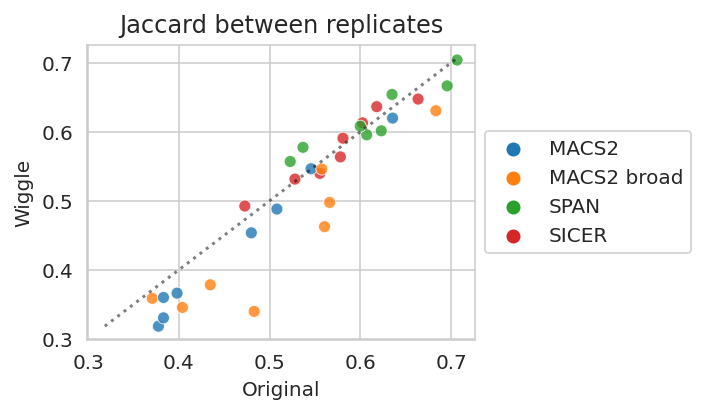

H3K4me1


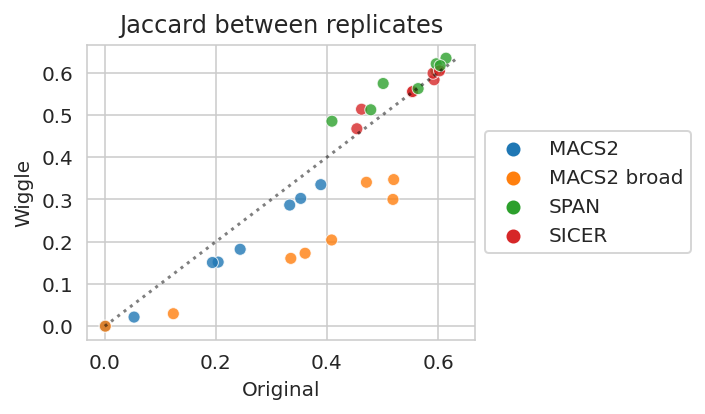

In [169]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    tm = t[t['modification'] == m]
    # tm = tm[tm['tool'] != 'SPAN']
    minxy = min(tm['Original'].min(), tm['Wiggle'].min())
    maxxy = max(tm['Original'].max(), tm['Wiggle'].max())
    sns.lineplot(x=[minxy, maxxy], y=[minxy, maxxy], color='black', ax=ax, alpha=0.5, linestyle='dotted')
    sns.scatterplot(tm,
                    palette=TOOLS_PALETTE,
                    hue_order=TOOLS,
                    # hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                    x='Original', y='Wiggle', hue='tool', alpha=0.8,
                    ax = ax)
    ax.set_title(f'Jaccard between replicates')
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# END